# ASR Dataset Quality Evaluation

Manual quality check of 100 randomly sampled transcriptions from the [dataset](https://huggingface.co/datasets/islomov/news_youtube_uzbek_speech_dataset). 
Evaluated Word Error Rate (WER), Character Error Rate (CER), and foreign language contamination.

**Methodology:**
1. Randomly sampled 100 audio files from the dataset
2. Extracted audio from parquet files using sample IDs
3. Manually verified and corrected transcriptions using custom HTML checker tool
4. Computed WER/CER metrics and foreign words count

In [1]:
import gc  # Garbage collector
import glob
import os

import pandas as pd
from tqdm import tqdm  # Progress bar library

SEED = 137
DATASET_DIR = "../datasets/uzbekvoice_dataset/data"
SAMPLED_AUDIO_DIR = os.path.join(DATASET_DIR, "sampled_audio")
ALL_DATA_PATH = os.path.join(DATASET_DIR, "dataset.csv")

SAMPLED_DATA_PATH = os.path.join(DATASET_DIR, "sampled.csv")
PROCESSED_AUDIO_STATS_PATH = os.path.join(DATASET_DIR, "processed_audio_stats.csv")
TRANSCRIPTION_RESULTS_PATH = os.path.join(DATASET_DIR, "google_spt_transcriptions.csv")

SAMPLED_DATA2_PATH = os.path.join(DATASET_DIR, "sampled2.csv")
PROCESSED_AUDIO_STATS2_PATH = os.path.join(DATASET_DIR, "processed_audio_stats2.csv")
TRANSCRIPTION_RESULTS2_PATH = os.path.join(DATASET_DIR, "google_spt_transcriptions2.csv")

### Create csv file with all data and computed statistics

In [2]:
def compute_statistics(df: pd.DataFrame, ignore_sampling_rate=True) -> dict:
    """Extract statistics without keeping audio in memory"""
    stats = {
        "id": [],
        "path": [],
        "word_count": [],
        "char_count": [],
    }
    if not ignore_sampling_rate:
        stats["sampling_rate"] = []

    for i in range(len(df)):
        stats["id"].append(int(df.iloc[i]["id"]))
        # Note: df.iloc[i]["path"]["path"] is duplicated even though its is different audio files from different speakers
        stats["path"].append(str(df.iloc[i]["id"]) + ".wav")  # directly output file, input file is .mp3 extension

        text = df.iloc[i]["sentence"]

        stats["char_count"].append(len(text))
        stats["word_count"].append(len(text.split()))

    return stats


parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")

all_data_df = pd.DataFrame()
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    df_partial = pd.read_parquet(parquet_file_path)
    stats = compute_statistics(df_partial)
    df_partial.drop(columns=["path"], inplace=True)

    df_partial = df_partial.merge(
        pd.DataFrame(stats),
        how="left",
        left_on="id",
        right_on="id"
    )

    # Combine all data
    all_data_df: pd.DataFrame = pd.concat([all_data_df, df_partial], ignore_index=True)

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

gc.collect()

all_data_df.set_index("id", inplace=True)
all_data_df.to_csv(ALL_DATA_PATH)

Found 33 parquet files. Started processing...



Processing files: 100%|██████████| 33/33 [01:22<00:00,  2.50s/it]


In [3]:
all_data_df.rename(columns={"client_id": "speaker_id", "downvotes_count": "down_votes", "upvotes_count": "up_votes",
                            "year_of_birth": "age"},
                   inplace=True)
all_data_df.drop(
    columns=["reported_reasons", "created_at", "skipped_clips", "original_sentence_id", "sentence_clips_count",
             "native_language"],
    inplace=True)

cols_in_order = ["path", "speaker_id", "accent_region", "up_votes", "down_votes", "reported_count", "age", "gender",
                 "duration", "word_count", "sentence"]
all_data_df = all_data_df[cols_in_order]
all_data_df.to_csv(ALL_DATA_PATH)

In [3]:
all_data_df = pd.read_csv(ALL_DATA_PATH, index_col="id")

print(all_data_df.info())
print(all_data_df.describe())
print("\nFirst few rows:")
all_data_df

<class 'pandas.core.frame.DataFrame'>
Index: 864778 entries, 210495 to 526178
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   path            864778 non-null  object 
 1   speaker_id      864778 non-null  object 
 2   accent_region   858950 non-null  object 
 3   up_votes        864778 non-null  int64  
 4   down_votes      864778 non-null  int64  
 5   reported_count  864778 non-null  int64  
 6   age             858950 non-null  object 
 7   gender          864778 non-null  object 
 8   duration        864778 non-null  float64
 9   word_count      864778 non-null  int64  
 10  sentence        864778 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 79.2+ MB
None
            up_votes     down_votes  reported_count       duration  \
count  864778.000000  864778.000000   864778.000000  864778.000000   
mean        0.695936       0.005198        0.008854       4.276783   
std         1

,path,speaker_id,accent_region,up_votes,down_votes,reported_count,age,gender,duration,word_count,sentence
id,,,,,,,,,,,
210495,210495.wav,6ff9168d-3398-412b-9510-7caa7628fae1,Farg'ona,0,0,0,18-24,female_feminine,1.908,3,Konsert yaxshi o‘tgan.
210496,210496.wav,e3bf850f-ae4b-424c-ab81-bddbab796b19,Namangan,0,0,0,19-29,female_feminine,3.204,4,Djigan Toshkentda konsert beradi.
210497,210497.wav,6ff9168d-3398-412b-9510-7caa7628fae1,Farg'ona,0,0,0,18-24,female_feminine,2.628,3,"Umuman olganda, qiziqmayman."
210498,210498.wav,348b2776-4432-44e7-868c-8fc11b674509,Toshkent viloyati,2,0,0,< 19,female_feminine,2.196,3,Lekin bolasi bo‘lmaydi.
210499,210499.wav,b2b2ee04-a86b-4ddc-8165-4be7a103fe2f,Jizzax,0,0,0,25-34,male_masculine,2.916,3,"Targ‘ibot qilishdi, tushuntirishdi."
...,...,...,...,...,...,...,...,...,...,...,...
526174,526174.wav,f3955702-ad1f-4896-b1f3-de8d2a5d381a,Jizzax,0,0,0,18-24,female_feminine,4.356,6,Toshkent shahrida alkogoldan zaharlanish holat...
526175,526175.wav,8a393ed4-c4c2-4f5f-8ea2-04401704ca56,Xorazm,0,0,0,18-24,female_feminine,2.808,6,"Agar u qo‘l qo‘ymasa, uni otishadi."
526176,526176.wav,d1f293f7-f89c-4455-91cc-140b0d4ac455,Samarqand,0,0,0,18-24,male_masculine,3.132,6,Voqea yuzasidan tergov ishlari olib borilmoqda.


In [3]:
# Fix age (year_of_birth) inconsistencies
def map_age_to_group(val):
    dataset_year = 2022

    # Convert to string to handle potential mixed types
    val_str = str(val).strip()

    # If it's already a range in your list, keep it
    if val_str in ["12-17", "< 19", "18-24", "19-29", "25-34", "30-39", "35-...", "40-49", "50-59", "60-69", "80-89",
                   "> 89"]:
        return val_str

    # Check if it's a Year of Birth (numeric and > 1900)
    try:
        num_val = float(val_str)
        if 1900 < num_val <= dataset_year:
            age = dataset_year - num_val

            # Mapping logic based on your specific groups
            if age < 12: return "Under 12"  # Optional: handling very young
            if 12 <= age <= 17: return "12-17"
            if 18 <= age <= 24: return "18-24"
            if 25 <= age <= 34: return "25-34"
            if 35 <= age <= 39: return "30-39"
            if 40 <= age <= 49: return "40-49"
            if 50 <= age <= 59: return "50-59"
            if 60 <= age <= 69: return "60-69"
            if 70 <= age <= 79: return "70-79"
            if 80 <= age <= 89: return "80-89"
            if age > 89: return "> 89"

            return "Other"

    except ValueError:
        return "Unknown"  # For non-numeric garbage data


# Apply the function to your column
all_data_df["age"] = all_data_df["age"].apply(map_age_to_group)
all_data_df["age"].value_counts()

age
18-24     656642
25-34      58271
19-29      45884
< 19       42458
12-17      27759
35-...     23286
30-39       3613
40-49        440
> 89         264
80-89        203
50-59        120
60-69         10
Name: count, dtype: int64

In [4]:
uz_translation = {"Ayol": "female_feminine", "Erkak": "male_masculine"}  # like in Common Voice
all_data_df.loc[:, "gender"] = all_data_df["gender"].replace(uz_translation)

all_data_df.fillna({"gender": "not_specified"}, inplace=True)

all_data_df = all_data_df[all_data_df["duration"] < 30]  # There was only 10 outlier recordings
all_data_df.to_csv(ALL_DATA_PATH)

### Dataset statistics plotted

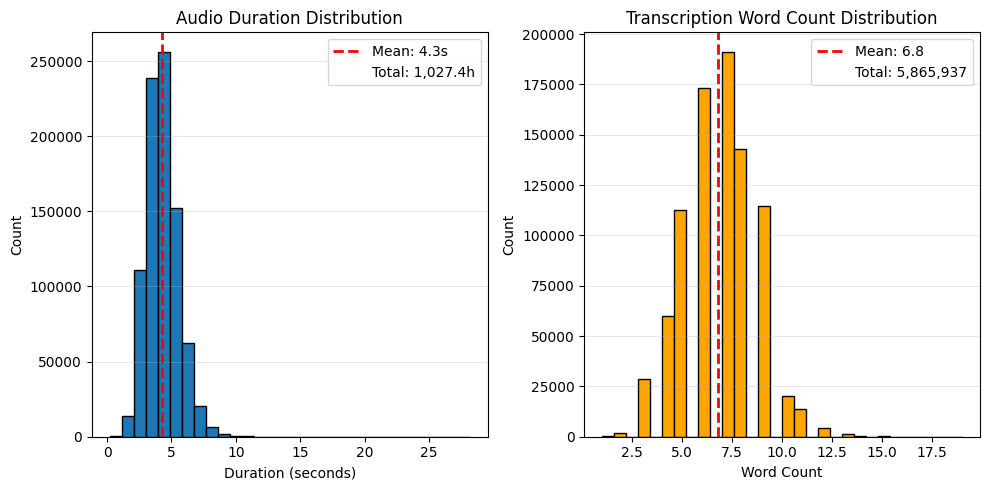

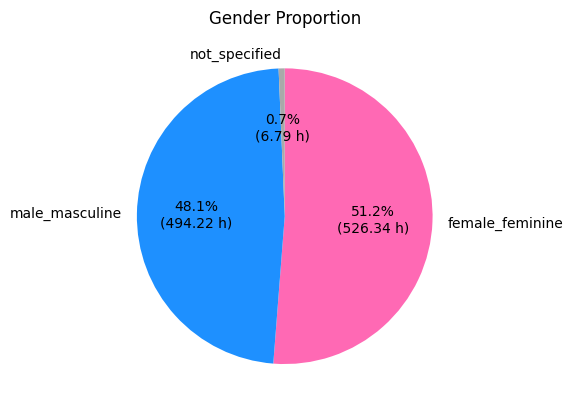

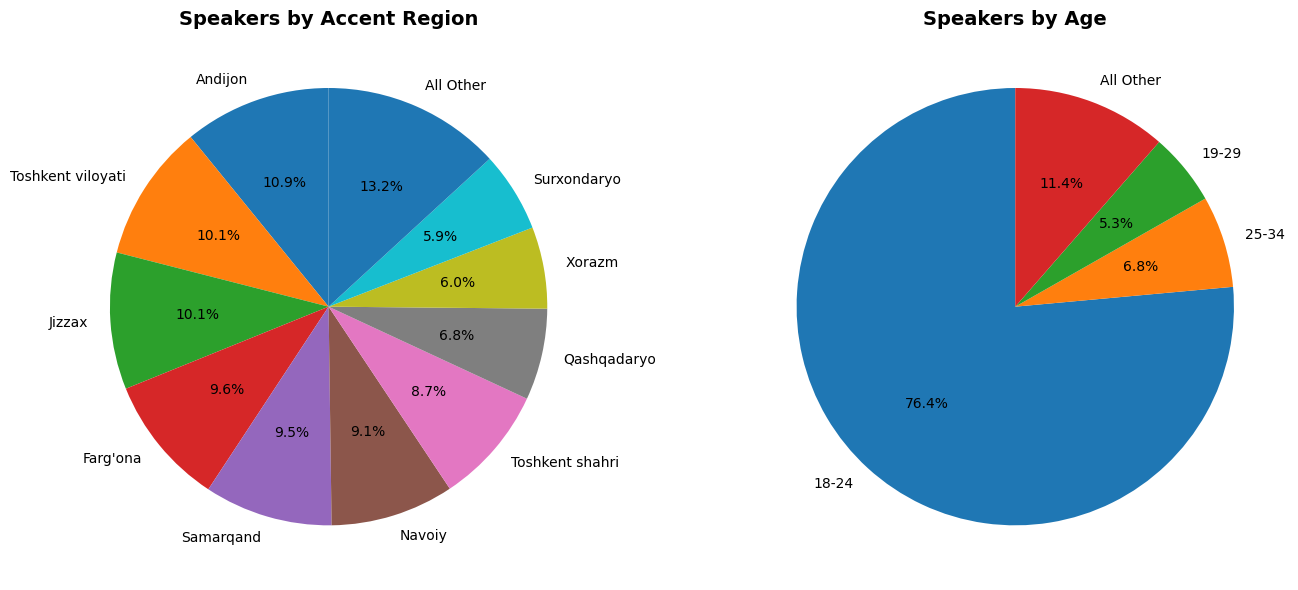


Total Unique Speakers: 5,576


speaker_id
4faeacd7-f209-47f1-80d7-47ff9969c7ce    33259
d1f293f7-f89c-4455-91cc-140b0d4ac455    32030
64f7ffe1-2c4e-459e-9155-5fc9a0bbe539    29510
231d3776-2dbe-4a42-a535-c67943427e3f    26706
8a393ed4-c4c2-4f5f-8ea2-04401704ca56    26621
                                        ...  
ec0b5010-1863-4873-acba-8b135da13f02        1
d9c9c4c5-5e54-4c7c-9203-3d26ef3c2147        1
92200a60-8711-41b4-81ae-561b40d60c34        1
f4de2a83-67a5-4886-9a29-aaf4e5465b0f        1
353dabcb-d42f-44ca-b423-2dea27b8d979        1
Name: count, Length: 5576, dtype: int64

In [4]:
from scripts.dataset_plotting import plot_distribution_graphs, plot_gender_pie_chart, \
    plot_accent_region_and_age_distribution

plot_distribution_graphs(all_data_df)
plot_gender_pie_chart(all_data_df)
plot_accent_region_and_age_distribution(all_data_df)

# Count recordings per speaker
speaker_counts = all_data_df["speaker_id"].value_counts()
print(f"\nTotal Unique Speakers: {len(speaker_counts):,.0f}")
speaker_counts

### Extract longer recordings

short_recordings: 
count                                    20000
unique                                    3957
top       c98a14fd-efaf-4219-b125-bf1a389bbf30
freq                                        19
Name: speaker_id, dtype: object

medium_recordings: 
count                                   133940
unique                                    3491
top       b35e4cb7-8c3b-4d96-be1e-d2eca1766857
freq                                      1100
Name: speaker_id, dtype: object

long_recordings: 
count                                     6246
unique                                     571
top       b2ea482e-0e57-428b-9a25-827582772fd7
freq                                       353
Name: speaker_id, dtype: object


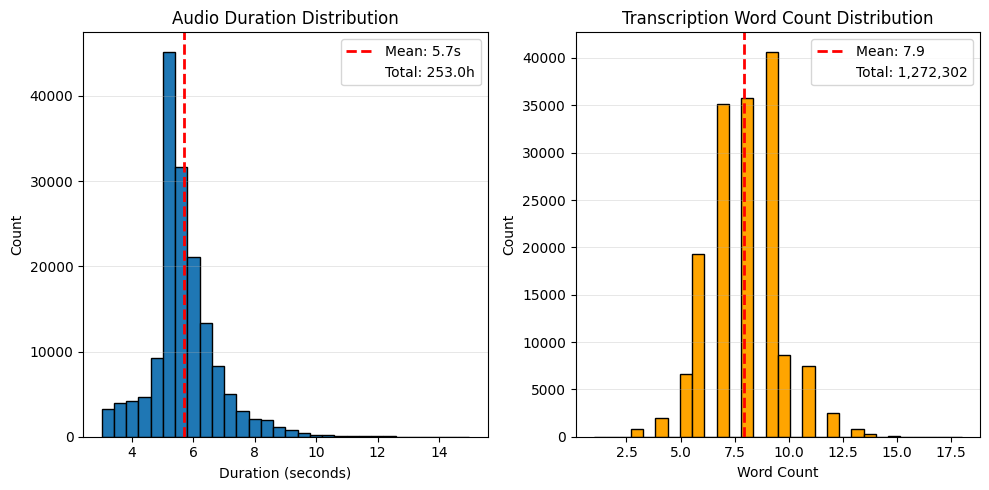

,speaker_id,path,accent_region,up_votes,down_votes,reported_count,age,gender,duration,word_count,sentence,net_votes
id,,,,,,,,,,,,
37,ad974593-4363-49c7-868b-24170166bdbf,37.wav,NaN,13,0,0,NaN,not_specified,9.576,17,"Agar biz chiqarayotgan qaror noto‘g‘ri bo‘lsa,...",13
39,ad974593-4363-49c7-868b-24170166bdbf,39.wav,NaN,0,0,1,NaN,not_specified,5.580,10,Diniy konfesiya rahbarlari Qurbon hayiti munos...,0
40,ad974593-4363-49c7-868b-24170166bdbf,40.wav,NaN,0,0,0,NaN,not_specified,4.428,8,Tramp Kim Chen Inga Vyetnamda uchrashishni tak...,0
43,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,43.wav,NaN,2,0,0,NaN,not_specified,9.468,14,"Uning tarkibidagi fitoestrogen, ayollar gormon...",2
44,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,44.wav,NaN,16,0,0,NaN,not_specified,6.228,11,O‘zbekistondagi oliy va o‘rta maxsus islom bil...,16
...,...,...,...,...,...,...,...,...,...,...,...,...
864861,1684927e-c0ee-4208-a6ea-ddc556296815,864861.wav,Andijon,0,0,0,25-34,male_masculine,6.480,9,ba’zi kishilarga mazkur ochiq sudda ishtirok e...,0
864862,1684927e-c0ee-4208-a6ea-ddc556296815,864862.wav,Andijon,0,0,0,25-34,male_masculine,8.568,11,Sud ibodatxonani buzish haqida qaror chiqardi....,0
864863,1684927e-c0ee-4208-a6ea-ddc556296815,864863.wav,Andijon,0,0,0,25-34,male_masculine,7.920,13,"– Ochig‘ini aytsam, shu vaqtga qadar zamonaviy...",0


In [5]:
# from scripts.dataset_plotting import plot_distribution_graphs

all_data_df = pd.read_csv(ALL_DATA_PATH, index_col="id")

# Sort by speaker_id for deterministic groupby order
all_data_df = all_data_df.sort_values("speaker_id")

short_audios = (all_data_df["duration"] >= 3) & (all_data_df["duration"] < 5)
medium_audios = (all_data_df["duration"] >= 5) & (all_data_df["duration"] < 8)
long_audios = (all_data_df["duration"] >= 8) & (all_data_df["duration"] <= 15)

short_samples = (
    all_data_df[short_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 30), random_state=SEED),
           include_groups=False)  # Maximum up to 30 recordings per speaker
    .reset_index(level=0)
).sample(20_000, weights="duration", random_state=SEED)
print(f"short_recordings: \n{short_samples["speaker_id"].describe()}")

medium_samples = (
    all_data_df[medium_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 1100), random_state=SEED),
           include_groups=False)  # Maximum up to 1100 recordings per speaker
    .reset_index(level=0)
)
print(f"\nmedium_recordings: \n{medium_samples["speaker_id"].describe()}")

long_samples = (
    all_data_df[long_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 500), random_state=SEED),
           include_groups=False)  # Maximum up to 500 recordings per speaker
    .reset_index(level=0)
)
print(f"\nlong_recordings: \n{long_samples["speaker_id"].describe()}")

sampled_df = pd.concat([short_samples, medium_samples, long_samples]).sort_index()

# Remove recordings with net_votes <= -5 (up_votes - down_votes)
sampled_df.loc[:, "net_votes"] = sampled_df["up_votes"] - sampled_df["down_votes"]
majority_down_voted_mask = sampled_df["net_votes"] <= -5
sampled_df = sampled_df[~majority_down_voted_mask]

sampled_df.to_csv(SAMPLED_DATA_PATH)

plot_distribution_graphs(sampled_df)

sampled_df

### Extract audios from parquet files to manually check the quality of the overall dataset

To extract audio files, you can either use streaming api from hugging face or use below function to extract from local parquet files

In [2]:

import scripts.audio_preprocessing as ap


def extract_and_normalize_audio_from_parquet(paths_to_extract: set | list):
    print(f"Need to extract {len(paths_to_extract)} audio files")
    ids_to_filter = set(
        map(lambda path: int(Path(path).stem), paths_to_extract)
    )

    # Create directory for extracted audio
    os.makedirs(SAMPLED_AUDIO_DIR, exist_ok=True)

    parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
    num_parquets = len(parquet_files)

    if num_parquets == 0:
        raise FileNotFoundError(f"No parquet files found. Exiting...")

    print(f"Found {num_parquets} parquet files. Started processing...\n")

    stats = []
    found_count = 0
    for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
        if found_count >= len(ids_to_filter):
            break

        df_partial = pd.read_parquet(parquet_file_path)

        # Filter to only rows we need.
        matching_rows = df_partial[df_partial["id"].isin(ids_to_filter)]

        if len(matching_rows) < 1:
            del df_partial
            continue

        # Extract and normalize audios from parquet files
        for _, row in matching_rows.iterrows():
            audio_bytes = row["path"]["bytes"]

            input_file_name = str(row["id"]) + ".mp3"
            output_file_name = str(row["id"]) + ".wav"
            output_path = os.path.join(SAMPLED_AUDIO_DIR, output_file_name)

            waveform, stat = ap.process_audio_bytes(
                input_file_name,
                audio_bytes,
                save_path=output_path,
                normalize=True,
                target_rms_db=-23.0,
                apply_highpass=True,
                highpass_cutoff=80.0,
                remove_silences=True,
                silence_threshold_db=-45.0,
                min_silence_duration=1.3
            )

            stats.append(stat)
            found_count += 1

        # Explicitly delete the dataframe with heavy audio bytes
        del df_partial
        gc.collect()

    print(f"\nExtracted and normalized {found_count} audio files to {SAMPLED_AUDIO_DIR}")
    return pd.DataFrame(stats)

In [3]:
from datasets import load_dataset, Audio
from pathlib import Path


def extract_and_normalize_audio_with_streaming(paths_to_extract: set | list):
    print(f"Need to extract {len(paths_to_extract)} audio files")
    ids_to_filter = set(
        map(lambda path: int(Path(path).stem), paths_to_extract)
    )

    # Load dataset in streaming mode
    dataset = load_dataset(
        "DavronSherbaev/uzbekvoice",
        streaming=True
    )

    # Access the train split
    dataset_stream = dataset['train'].cast_column('path', Audio(decode=False))

    print(f"Looking for {len(ids_to_filter)} missing audio files...")

    stats = []
    found_count = 0

    # Create progress bar with found/total instead of iteration count
    pbar = tqdm(total=len(ids_to_filter), desc="Finding audios", unit="found")

    for row in dataset_stream:
        if int(row["id"]) not in ids_to_filter:
            continue

        audio_bytes = row["path"]["bytes"]  # This should work with non-streaming

        input_file_name = str(row["id"]) + ".mp3"
        output_file_name = str(row["id"]) + ".wav"
        output_path = os.path.join(SAMPLED_AUDIO_DIR, output_file_name)

        waveform, stat = ap.process_audio_bytes(
            input_file_name,
            audio_bytes,
            save_path=output_path,
            normalize=True,
            target_rms_db=-23.0,
            apply_highpass=True,
            highpass_cutoff=80.0,
            remove_silences=True,
            silence_threshold_db=-45.0,
            min_silence_duration=1.3
        )

        stats.append(stat)
        found_count += 1
        pbar.update(1)

    print(f"\nExtracted and normalized {found_count} audio files to {SAMPLED_AUDIO_DIR}")
    return pd.DataFrame(stats)

In [8]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

# Extract sampled audios from local parquets files
processed_audio_stats_df = extract_and_normalize_audio_from_parquet(sampled_df["path"].tolist())
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH, index=False)
# OR
# Extract sampled audios using streaming api
# processed_audio_stats_df = extract_and_normalize_audio_with_streaming(sampled_df["path"].tolist())
# processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH, index=False)

processed_audio_stats_df

Need to extract 160118 audio files
Found 33 parquet files. Started processing...



Processing files: 100%|██████████| 33/33 [26:24<00:00, 48.02s/it]



Extracted and normalized 160118 audio files to ../datasets/uzbekvoice_dataset/data/sampled_audio


,input_audio_filename,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude,is_clipped
0,210508.mp3,-23.8663,-23.1517,3.348,3.348,0.0,0.6810,False
1,210517.mp3,-23.6393,-23.3166,3.348,3.348,0.0,0.7544,False
2,210526.mp3,-19.5121,-23.1433,3.888,3.888,0.0,0.5130,False
3,210541.mp3,-23.1994,-23.4505,3.744,3.744,0.0,0.7345,False
4,210568.mp3,-18.5818,-23.1065,3.564,3.564,0.0,0.4119,False
...,...,...,...,...,...,...,...,...
160113,525324.mp3,-13.3501,-23.0912,5.040,5.040,0.0,0.3424,False
160114,525328.mp3,-17.4020,-23.1183,5.580,5.580,0.0,0.4805,False
160115,525340.mp3,-15.2267,-23.1190,5.760,5.760,0.0,0.4044,False
160116,525442.mp3,-18.5884,-23.1401,5.688,5.688,0.0,0.4878,False


In [9]:
processed_audio_stats_df.describe()

/home/optimus/My Kingdom/Projects/UzbekASR/uzbek-automatic-speech-recognition/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/optimus/My Kingdom/Projects/UzbekASR/uzbek-automatic-speech-recognition/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude
count,160118.0000,160118.0000,160118.000000,160118.000000,160118.000000,160118.000000
mean,-inf,-inf,5.689164,5.659785,0.029379,0.485856
std,NaN,NaN,1.093014,1.076666,0.226486,0.106214
min,-inf,-inf,3.024000,0.500000,0.000000,0.000000
25%,-19.4580,-23.1743,5.148000,5.112000,0.000000,0.410200
50%,-17.7396,-23.1348,5.508000,5.508000,0.000000,0.471900
75%,-16.2320,-23.1072,6.156000,6.120000,0.000000,0.546600
max,-6.6981,-23.0358,14.976000,14.976000,8.434000,0.950000


In [10]:
import numpy as np

processed_audio_stats_df = pd.read_csv(PROCESSED_AUDIO_STATS_PATH)
# Update all rows in the filename column
processed_audio_stats_df.loc[:, "input_audio_filename"] = (
    processed_audio_stats_df["input_audio_filename"].str.replace(r"\.mp3$", ".wav", regex=True)
)

# Remove silent recordings
is_inf = np.isinf(processed_audio_stats_df["original_rms_db"])
silent_recordings = (
    processed_audio_stats_df[is_inf]["input_audio_filename"].tolist()
)

sampled_df = sampled_df[~sampled_df["path"].isin(silent_recordings)]
print(f"Identified and removed {len(silent_recordings)} silent recordings.")

processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH, index=False)
sampled_df.to_csv(SAMPLED_DATA_PATH)

Identified and removed 5 silent recordings.


In [13]:
processed_audio_stats_df[~is_inf].describe()

,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude
count,160113.000000,160113.000000,160113.000000,160113.000000,160113.000000,160113.000000
mean,-17.998629,-23.150003,5.689182,5.659946,0.029236,0.485871
std,2.606981,0.075404,1.093008,1.076296,0.224939,0.106181
min,-40.482200,-27.484100,3.024000,1.430000,0.000000,0.154100
25%,-19.457800,-23.174300,5.148000,5.112000,0.000000,0.410200
50%,-17.739500,-23.134800,5.508000,5.508000,0.000000,0.471900
75%,-16.232000,-23.107200,6.156000,6.120000,0.000000,0.546600
max,-6.698100,-23.035800,14.976000,14.976000,8.434000,0.950000


In [14]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
processed_audio_stats_df = pd.read_csv(PROCESSED_AUDIO_STATS_PATH)

old_total_duration = sampled_df["duration"].sum() / 3600
old_duration_mean = sampled_df["duration"].mean()

# --- Replace sampled_df.duration using processed_audio_stats_df.final_duration ---

# Merge final_duration into the sampled dataframe
sampled_df = sampled_df.merge(
    processed_audio_stats_df[["input_audio_filename", "final_duration"]],
    how="left",
    left_on="path",
    right_on="input_audio_filename"
)

# Replace duration only where we have final_duration
sampled_df["duration"] = (
    sampled_df["final_duration"].combine_first(sampled_df["duration"])
)

# Drop helper columns
sampled_df = sampled_df.drop(columns=["final_duration"])

# --- Remove suspiciously short and short recordings  ---

# Remove very short audios
mask_short_audio = (processed_audio_stats_df["final_duration"] < 3)
paths_to_remove = processed_audio_stats_df.loc[mask_short_audio, "input_audio_filename"].tolist()

total_reduced_duration = processed_audio_stats_df["reduced_duration"].sum() / 3600

# Remove these recordings entirely
sampled_df = sampled_df[
    ~sampled_df["path"].isin(paths_to_remove)
]
print(f"{len(paths_to_remove)} recordings are removed from the sample")

# Updated totals
current_total_duration = processed_audio_stats_df["final_duration"].sum() / 3600
current_duration_mean = processed_audio_stats_df["final_duration"].mean()

sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

print(
    f"Before audio preprocessing: total duration - {old_total_duration:,.3f} h | mean {old_duration_mean:,.1f} s"
)
print(
    f"After audio preprocessing: total duration - {current_total_duration:,.3f} h "
    f"(reduced {total_reduced_duration * 60:.0f} min) | mean {current_duration_mean:,.1f} s"
)

sampled_df

49 recordings are removed from the sample
Before audio preprocessing: total duration - 253.031 h | mean 5.7 s
After audio preprocessing: total duration - 251.732 h (reduced 78 min) | mean 5.7 s


,speaker_id,path,accent_region,up_votes,down_votes,reported_count,age,gender,duration,word_count,sentence,net_votes,input_audio_filename
0,ad974593-4363-49c7-868b-24170166bdbf,37.wav,NaN,13,0,0,NaN,not_specified,9.576,17,"Agar biz chiqarayotgan qaror noto‘g‘ri bo‘lsa,...",13,NaN
1,ad974593-4363-49c7-868b-24170166bdbf,39.wav,NaN,0,0,1,NaN,not_specified,5.580,10,Diniy konfesiya rahbarlari Qurbon hayiti munos...,0,NaN
2,ad974593-4363-49c7-868b-24170166bdbf,40.wav,NaN,0,0,0,NaN,not_specified,4.428,8,Tramp Kim Chen Inga Vyetnamda uchrashishni tak...,0,NaN
3,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,43.wav,NaN,2,0,0,NaN,not_specified,9.468,14,"Uning tarkibidagi fitoestrogen, ayollar gormon...",2,NaN
4,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,44.wav,NaN,16,0,0,NaN,not_specified,6.228,11,O‘zbekistondagi oliy va o‘rta maxsus islom bil...,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160108,1684927e-c0ee-4208-a6ea-ddc556296815,864861.wav,Andijon,0,0,0,25-34,male_masculine,6.480,9,ba’zi kishilarga mazkur ochiq sudda ishtirok e...,0,NaN
160109,1684927e-c0ee-4208-a6ea-ddc556296815,864862.wav,Andijon,0,0,0,25-34,male_masculine,8.568,11,Sud ibodatxonani buzish haqida qaror chiqardi....,0,NaN
160110,1684927e-c0ee-4208-a6ea-ddc556296815,864863.wav,Andijon,0,0,0,25-34,male_masculine,7.920,13,"– Ochig‘ini aytsam, shu vaqtga qadar zamonaviy...",0,NaN
160111,1684927e-c0ee-4208-a6ea-ddc556296815,864865.wav,Andijon,0,0,0,25-34,male_masculine,7.488,10,Olisda tahsil oladigan talabalar saylovda qays...,0,NaN


I just had to divide the sample into two because my Google Console credits was not enough for the whole sample. You are welcome to do in one run.

In [2]:
from sklearn.model_selection import train_test_split

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
google_spt_check_1, google_spt_check_2 = train_test_split(
    sampled_df[sampled_df["net_votes"] < 5],
    test_size=0.5,
    random_state=SEED
)

google_spt_check_1.to_csv(os.path.join(DATASET_DIR, "google_spt_check_1.csv"))
google_spt_check_2.to_csv(os.path.join(DATASET_DIR, "google_spt_check_2.csv"))

In [22]:
# Before running set your own PROJECT_ID to .env file (e.g. GOOGLE_CLOUD_PROJECT="your id here")
# from pathlib import Path
from scripts import google_transcribe

# Configuration
CHECKPOINT_INTERVAL = 1000  # Save every 1000 audio files
CHECKPOINT_PATH = "transcription_checkpoint.csv"

google_spt_check_2 = pd.read_csv(os.path.join(DATASET_DIR, "google_spt_check_2.csv"), index_col="id")

# Prepare audio paths
audio_paths = google_spt_check_2["path"].apply(
    lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name)
).tolist()

# Check for existing checkpoint
existing_results = []
processed_paths = set()

if os.path.exists(CHECKPOINT_PATH):
    print(f"Found existing checkpoint: {CHECKPOINT_PATH}")
    checkpoint_df = pd.read_csv(CHECKPOINT_PATH)
    existing_results = checkpoint_df.to_dict('records')
    processed_paths = set(checkpoint_df["path"].apply(lambda x: Path(x).name))
    print(f"Resuming from checkpoint with {len(existing_results)} already processed files")

    # Filter out already processed files
    audio_paths = [
        path for path in audio_paths
        if Path(path).name not in processed_paths
    ]
    print(f"Remaining files to process: {len(audio_paths)}")

# Process files in parallel using two regions
print(f"\nProcessing {len(audio_paths)} audio files using 2 regions (eu, us)...")
print("Starting parallel transcription with checkpoint saving...\n")


def save_checkpoint(results_list, is_final=False):
    """Save current results to checkpoint file"""
    df = pd.DataFrame(results_list)
    df.to_csv(CHECKPOINT_PATH, index_label="id")
    status = "FINAL" if is_final else "CHECKPOINT"
    print(f"\n[{status}] Saved {len(results_list)} results to: {CHECKPOINT_PATH}")


try:
    # Start with existing results
    all_results = existing_results.copy()

    # Process remaining files
    if audio_paths:
        results = google_transcribe.transcribe_batch_parallel(
            audio_paths=audio_paths,
            regions=["eu", "us"],
            max_workers=30,
            checkpoint_callback=lambda new_results: save_checkpoint(all_results + new_results),
            checkpoint_interval=CHECKPOINT_INTERVAL
        )
        all_results.extend(results)

    # Save final results
    save_checkpoint(all_results, is_final=True)

except KeyboardInterrupt:
    print("\n\n⚠️  Process interrupted by user!")
    print(f"Partial results saved to checkpoint: {CHECKPOINT_PATH}")
    print("You can resume by running this script again.")
    raise
except Exception as err:
    print(f"\n❌ Critical error during parallel processing: {type(err).__name__}: {err}")
    print(f"Partial results saved to checkpoint: {CHECKPOINT_PATH}")
    raise

# Process final results
predicted_transcriptions = []
failed_count = 0
success_count = 0

for result in all_results:
    transcription_entry = {
        "path": result["path"],
        "predicted_sentence": result["predicted_sentence"],
        "error_message": result["error_message"],
        "error_type": result["error_type"],
    }

    predicted_transcriptions.append(transcription_entry)

    if result["predicted_sentence"] is not None:
        success_count += 1
    else:
        failed_count += 1

# Save final results to the main output file
predicted_transcripts_df = pd.DataFrame(predicted_transcriptions)
predicted_transcripts_df.to_csv(TRANSCRIPTION_RESULTS_PATH, index_label="id")
print(f"\n✓ Saved final transcription results to: {TRANSCRIPTION_RESULTS_PATH}")

# Clean up checkpoint file
if os.path.exists(CHECKPOINT_PATH):
    os.remove(CHECKPOINT_PATH)
    print(f"✓ Removed checkpoint file: {CHECKPOINT_PATH}")

print(f"\n{'=' * 60}")
print(f"Transcription Complete!")
print(f"{'=' * 60}")
print(f"✓ Successfully transcribed: {success_count}")
print(f"✗ Failed: {failed_count}")
print(f"Success rate: {success_count / len(google_spt_check_2) * 100:.2f}%")

predicted_transcripts_df


Processing 8008 audio files using 2 regions (eu, us)...
Starting parallel transcription with checkpoint saving...

Using 2 project(s) across 2 region(s)
Total combinations: 4


Transcribing:  12%|█▏        | 999/8008 [01:55<10:31, 11.10file/s]


[CHECKPOINT] Saved 1000 results to: transcription_checkpoint.csv


Transcribing:  25%|██▍       | 2000/8008 [04:01<15:01,  6.66file/s]


[CHECKPOINT] Saved 2000 results to: transcription_checkpoint.csv


Transcribing:  37%|███▋      | 2999/8008 [06:03<08:50,  9.45file/s]


[CHECKPOINT] Saved 3000 results to: transcription_checkpoint.csv


Transcribing:  50%|████▉     | 4000/8008 [08:20<07:43,  8.64file/s]


[CHECKPOINT] Saved 4000 results to: transcription_checkpoint.csv


Transcribing:  62%|██████▏   | 5001/8008 [10:35<04:58, 10.08file/s]


[CHECKPOINT] Saved 5000 results to: transcription_checkpoint.csv


Transcribing:  75%|███████▍  | 6000/8008 [12:45<03:15, 10.28file/s]


[CHECKPOINT] Saved 6000 results to: transcription_checkpoint.csv


Transcribing:  87%|████████▋ | 7002/8008 [15:04<02:21,  7.11file/s]


[CHECKPOINT] Saved 7000 results to: transcription_checkpoint.csv


Transcribing: 100%|█████████▉| 7997/8008 [17:26<00:01,  6.54file/s]


[CHECKPOINT] Saved 8000 results to: transcription_checkpoint.csv


Transcribing: 100%|██████████| 8008/8008 [17:27<00:00,  7.64file/s]


[CHECKPOINT] Saved 8008 results to: transcription_checkpoint.csv

[FINAL] Saved 8008 results to: transcription_checkpoint.csv

✓ Saved final transcription results to: ../datasets/uzbekvoice_dataset/data/google_spt_transcriptions.csv
✓ Removed checkpoint file: transcription_checkpoint.csv

Transcription Complete!
✓ Successfully transcribed: 8008
✗ Failed: 0
Success rate: 100.00%


,path,predicted_sentence,error_message,error_type
0,../datasets/uzbekvoice_dataset/data/sampled_au...,O'rtamizda muammo bo'lmagan.,None,None
1,../datasets/uzbekvoice_dataset/data/sampled_au...,Toshkentda qor fotoreportaj,None,None
2,../datasets/uzbekvoice_dataset/data/sampled_au...,Abdurahmon Hamidov huquqshunos,None,None
3,../datasets/uzbekvoice_dataset/data/sampled_au...,Shaharlar samolyotlardan bombardirlandi.,None,None
4,../datasets/uzbekvoice_dataset/data/sampled_au...,"Ha, to'g'ri esladingiz.",None,None
...,...,...,...,...
8003,../datasets/uzbekvoice_dataset/data/sampled_au...,617,None,None
8004,../datasets/uzbekvoice_dataset/data/sampled_au...,Yurak urishi yaxshi edi.,None,None
8005,../datasets/uzbekvoice_dataset/data/sampled_au...,"Bir hafta o'tib, ular uchun charter reys tashk...",None,None
8006,../datasets/uzbekvoice_dataset/data/sampled_au...,kompyuter fanlari va texnologik menejment yo'n...,None,None


In [5]:
google_spt_checked_1 = pd.read_csv(os.path.join(DATASET_DIR, "google_spt_transcriptions1.csv"), index_col="id")
google_spt_checked_2 = pd.read_csv(os.path.join(DATASET_DIR, "google_spt_transcriptions2.csv"), index_col="id")
# google_spt_checked_3 is just 2nd part that has errors
google_spt_checked_3 = pd.read_csv(os.path.join(DATASET_DIR, "google_spt_transcriptions3.csv"), index_col="id")

google_spt_checked_1["path"] = google_spt_checked_1["path"].apply(lambda x: Path(x).name)
google_spt_checked_2["path"] = google_spt_checked_2["path"].apply(lambda x: Path(x).name)
google_spt_checked_3["path"] = google_spt_checked_3["path"].apply(lambda x: Path(x).name)

# Check if rows with errors in checked_2 match paths in checked_3
errors_in_2 = google_spt_checked_2[~google_spt_checked_2["error_message"].isna()]
matches = errors_in_2["path"].isin(google_spt_checked_3["path"])

# Update predicted_sentence for matched rows
for path in errors_in_2[matches]["path"]:
    # Get the predicted_sentence from checked_3
    pred_sentence = google_spt_checked_3[google_spt_checked_3["path"] == path]["predicted_sentence"].values[0]
    # Update in checked_2
    google_spt_checked_2.loc[google_spt_checked_2["path"] == path, "predicted_sentence"] = pred_sentence

google_spt_checked = pd.concat([google_spt_checked_1, google_spt_checked_2], ignore_index=True).sort_values("path")
google_spt_checked.to_csv(TRANSCRIPTION_RESULTS_PATH, index_label="id")
google_spt_checked

,path,predicted_sentence,error_message,error_type
60190,100004.wav,Hozirda qo'shimcha surishtiruv ishlari davom e...,NaN,NaN
116274,100005.wav,Aksariyat foydalanuvchilar esa ushbu tashabbus...,NaN,NaN
104647,100023.wav,Ularning orasida bir bola ham bor.,NaN,NaN
36636,100024.wav,O'z qozig'imiz atrofida aylanishimiz shu menim...,NaN,NaN
58402,100030.wav,"Avvalo, podstansiyalar yetarlicha himoyaga ega...",NaN,NaN
...,...,...,...,...
67083,99993.wav,Zangiota majmuasidagi qurilish va obodonlashti...,NaN,NaN
13948,99994.wav,Amerikalik olimlar yerga o'xshash sayyorani an...,NaN,NaN
140650,99995.wav,O'lim holati ayol kishida qayd etilgan.,NaN,NaN
66942,99996.wav,Bo'sh koyka o'rinlar qolmadi. Habibulla Oqilov,NaN,NaN


In [21]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
predicted_transcripts_df = pd.read_csv(TRANSCRIPTION_RESULTS_PATH, index_col="id")

print(predicted_transcripts_df.info())

# Merge transcription results with original data
sampled_df = sampled_df.merge(
    predicted_transcripts_df,
    left_on="path",
    right_on="path",
    how="left"
)

sampled_df.drop(columns=["error_message", "error_type", "input_audio_filename", "char_count"], inplace=True,
                errors="ignore")
sampled_df.rename(columns={"sentence": "text_original", "predicted_sentence": "text_spt"}, inplace=True)

# Reorder columns
cols = list(sampled_df.columns)
cols.remove("net_votes")
cols.remove("text_original")
cols.insert(5, "net_votes")
cols.insert(-1, "text_original")
sampled_df = sampled_df[cols]

sampled_df

<class 'pandas.core.frame.DataFrame'>
Index: 160125 entries, 0 to 257646
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   path                160125 non-null  object
 1   predicted_sentence  159876 non-null  object
 2   error_message       1101 non-null    object
 3   error_type          1101 non-null    object
dtypes: object(4)
memory usage: 6.1+ MB
None


,speaker_id,path,accent_region,up_votes,down_votes,net_votes,reported_count,age,gender,duration,word_count,text_original,text_spt
0,ad974593-4363-49c7-868b-24170166bdbf,37.wav,NaN,13,0,13,0,NaN,not_specified,9.576,17,"Agar biz chiqarayotgan qaror noto‘g‘ri bo‘lsa,...","Agar biz chiqarayotgan qaror noto'g'ri bo'lsa,..."
1,ad974593-4363-49c7-868b-24170166bdbf,39.wav,NaN,0,0,0,1,NaN,not_specified,5.580,10,Diniy konfesiya rahbarlari Qurbon hayiti munos...,Diniy konferensiya rahbarlari Qurbon hayiti mu...
2,ad974593-4363-49c7-868b-24170166bdbf,40.wav,NaN,0,0,0,0,NaN,not_specified,4.428,8,Tramp Kim Chen Inga Vyetnamda uchrashishni tak...,Trump Kim Jong Unga Vyetnam uchrashishni takli...
3,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,43.wav,NaN,2,0,2,0,NaN,not_specified,9.468,14,"Uning tarkibidagi fitoestrogen, ayollar gormon...",Uning tarkibidagi fitoestrogen ayollar gormoni...
4,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,44.wav,NaN,16,0,16,0,NaN,not_specified,6.228,11,O‘zbekistondagi oliy va o‘rta maxsus islom bil...,O'zbekistondagi oliy va o'rta maxsus islom bil...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160127,1684927e-c0ee-4208-a6ea-ddc556296815,864861.wav,Andijon,0,0,0,0,25-34,male_masculine,6.480,9,ba’zi kishilarga mazkur ochiq sudda ishtirok e...,Ba'zi kishilarga mazkur ochiq sudda ishtirok e...
160128,1684927e-c0ee-4208-a6ea-ddc556296815,864862.wav,Andijon,0,0,0,0,25-34,male_masculine,8.568,11,Sud ibodatxonani buzish haqida qaror chiqardi....,Sud ibodatxonani buzish haqida qaror chiqardi....
160129,1684927e-c0ee-4208-a6ea-ddc556296815,864863.wav,Andijon,0,0,0,0,25-34,male_masculine,7.920,13,"– Ochig‘ini aytsam, shu vaqtga qadar zamonaviy...","Ochig'ini aytsam, shu vaqtga qadar zamonaviy b..."
160130,1684927e-c0ee-4208-a6ea-ddc556296815,864865.wav,Andijon,0,0,0,0,25-34,male_masculine,7.488,10,Olisda tahsil oladigan talabalar saylovda qays...,Olisda tahsil oladigan talabalar saylovda qays...


In [22]:
# Check if it contains number in digits and number in words (136 000 - bir yuz o'ttiz olti ming)
pattern = r"^(\d+(?: \d{3})*) - [\w| |']+$"
mask = sampled_df["text_original"].str.contains(pattern, regex=True, na=False)

print(f"Affected number of rows: {len(sampled_df[mask])}")
print("\nRandom 5 rows that matches the pattern:")
matched_5_rows = sampled_df[mask][["path", "text_original", "text_spt"]].sample(5)

sampled_df.loc[mask, "text_original"] = sampled_df.loc[mask, "text_original"].str.extract(pattern, expand=False)
matched_5_rows

Affected number of rows: 739

Random 5 rows that matches the pattern:


/tmp/ipykernel_671408/2027385461.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = sampled_df["text_original"].str.contains(pattern, regex=True, na=False)


,path,text_original,text_spt
157500,856424.wav,690 849 - olti yuz to'qson ming sakkiz yuz qir...,690849
157657,856886.wav,552 997 - besh yuz ellik ikki ming to'qqiz yuz...,552997
158073,857956.wav,5 917 883 - besh million to'qqiz yuz o'n yetti...,5 917 883
158507,859919.wav,668 997 - olti yuz oltmish sakkiz ming to'qqiz...,668997
158295,858914.wav,690 849 - olti yuz to'qson ming sakkiz yuz qir...,690849


In [23]:


# Apply similarity metrics to each row
metrics = sampled_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["text_original"],
        hypothesis=row["text_spt"],  # Google SPT generated text
    ),
    axis=1
)

# Convert list of dicts → DataFrame
metrics_df = pd.DataFrame(metrics.tolist())

# Merge metric columns back into main DataFrame and save
sampled_df: pd.DataFrame = pd.concat([sampled_df, metrics_df], axis=1)

sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")
sampled_df.sort_values("wer", ascending=False)

While converting '1 000 793 000 677 000' to number, IndexError error occurred: list index out of range
While converting '6 000 000 127 318' to number, IndexError error occurred: list index out of range


,speaker_id,path,accent_region,up_votes,down_votes,net_votes,reported_count,age,gender,duration,word_count,text_original,text_spt,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
85678,6db67690-f32d-4a63-bca1-b143c55e6fc6,445668.wav,Toshkent shahri,0,0,0,0,18-24,female_feminine,7.992,9,Yancheng Dafeng Dream Maze labirinti Xitoyning...,Yancheng da joylashgan Yancheng da joylashgan ...,yancheng dafeng dream maze labirinti xitoyning...,yancheng da joylashgan yancheng da joylashgan ...,684.4444,589.8000,0.0005,9,6162
139364,56ac8e86-b8c9-4879-a342-0eeb94f686fc,768177.wav,Qashqadaryo,0,0,0,0,< 19,female_feminine,9.936,11,Farmon bilan yuridik taʼlim va fanni yana-da r...,Farom bilan yurgan edim va va va va va va va v...,farmon bilan yuridik ta'lim va fanni yana-da r...,farom bilan yurgan edim va va va va va va va v...,583.8182,200.5000,0.0018,11,6424
143529,56ac8e86-b8c9-4879-a342-0eeb94f686fc,789197.wav,Qashqadaryo,0,0,0,0,< 19,female_feminine,5.112,7,nimaga instagramda shu mashhur insonni hayotin...,Instagramda shu mashhur insonni hayotini le le...,nimaga instagramda shu mashhur insonni hayotin...,instagramda shu mashhur insonni hayotini le le...,472.0000,157.3175,0.0086,7,3308
119926,fdef1682-7435-4a3c-9338-25b7bff2c822,664654.wav,Samarqand,0,0,0,0,18-24,female_feminine,5.616,8,"Pudradan foydalanishda rangsiz, uqalanib ketma...","pudradan foydalanishda rangsiz, uqalanishda ra...",pudradan foydalanishda rangsiz uqalanib ketmay...,pudradan foydalanishda rangsiz uqalanishda ran...,325.2500,324.7625,0.0029,8,2605
21482,b2ea482e-0e57-428b-9a25-827582772fd7,131389.wav,Sirdaryo,0,4,-4,0,25-34,male_masculine,14.148,7,Buning uchun pushti suyuqlik mitselyar suv ish...,"Buning uchun pochti suyuqlik, biz, biz, biz, b...",buning uchun pushti suyuqlik mitselyar suv ish...,buning uchun pochti suyuqlik biz biz biz biz b...,184.1429,95.3148,0.0103,7,1292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84561,81a0d023-f96d-4f57-9f6d-ada24db5990a,443293.wav,Surxondaryo,0,0,0,0,< 19,female_feminine,5.256,9,Bu Xalqaro fuqarolik aviatsiyasi tashkiloti ta...,Bu Xalqaro fuqarolik aviatsiyasi tashkiloti ta...,bu xalqaro fuqarolik aviatsiyasi tashkiloti ta...,bu xalqaro fuqarolik aviatsiyasi tashkiloti ta...,0.0000,0.0000,1.0000,9,9
84560,a61b9e67-3329-46d4-aba5-b58d37f5d253,443292.wav,Namangan,0,0,0,0,18-24,female_feminine,6.516,9,Yig‘ilishda pedagog kadrlar malakasini oshiris...,Yig'ilishda pedagog kadrlar malakasini oshiris...,yig'ilishda pedagog kadrlar malakasini oshiris...,yig'ilishda pedagog kadrlar malakasini oshiris...,0.0000,0.0000,1.0000,9,9
84556,085114ea-318c-4a90-807f-6804719bce6d,443285.wav,Farg'ona,0,0,0,0,18-24,male_masculine,5.760,9,Nega boshqaruvli kosmonavtikada Rossiyaning yu...,Nega boshqaruvli kosmonavtikada Rossiyaning yu...,nega boshqaruvli kosmonavtikada rossiyaning yu...,nega boshqaruvli kosmonavtikada rossiyaning yu...,0.0000,0.0000,1.0000,9,9
84570,a6c5718b-6dfb-4ac1-a7c4-ecdea031ec13,443308.wav,Xorazm,0,0,0,0,18-24,female_feminine,7.092,9,Hindistondagi aviabazada yana o‘q va portlash ...,Hindistondagi aviabazada yana o'q va portlash ...,hindistondagi aviabazada yana o'q va portlash ...,hindistondagi aviabazada yana o'q va portlash ...,0.0000,0.0000,1.0000,9,9


In [24]:
duration_with_high_wer = sampled_df[sampled_df["wer"] >= 1.0]["duration"].sum() / 3600
estimated_original_wer = sampled_df[sampled_df["wer"] < 1.0]["wer"].mean()
print(
    f"Estimated rough WER: {estimated_original_wer * 100:.2f}% (after removing WER >= 100%, amounting {duration_with_high_wer:.2f} hours)")

Estimated rough WER: 8.67% (after removing WER >= 100%, amounting 1.66 hours)


In [26]:
from scripts.uzbek_text_normalizer import normalize_text

# Add back of net_votes >= 5 as text_spt generated
mask = sampled_df["net_votes"] >= 5
sampled_df.loc[mask, "text_spt"] = sampled_df.loc[mask, "text_original"]
sampled_df.loc[mask, "hyp_normalized"] = sampled_df.loc[mask, "text_spt"].apply(
    lambda text: normalize_text(
        text,
        should_normalize_numbers_to_words=True,
        should_remove_punctuations=True,
        should_lowercase_text=True,
        should_remove_ellipsis=True,
    ))
sampled_df.loc[mask, "wer"] = 0.0
sampled_df.loc[mask, "cer"] = 0.0
sampled_df.loc[mask, "sequence_similarity"] = 1.0
sampled_df.loc[mask, "hyp_word_count"] = sampled_df.loc[mask, "ref_word_count"]

sampled_df.info()
sampled_df.to_csv(os.path.join(DATASET_DIR, "sampled_before_wer_filtering.csv"), index_label="id")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160132 entries, 0 to 160131
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   speaker_id           160132 non-null  object 
 1   path                 160132 non-null  object 
 2   accent_region        158702 non-null  object 
 3   up_votes             160132 non-null  int64  
 4   down_votes           160132 non-null  int64  
 5   net_votes            160132 non-null  int64  
 6   reported_count       160132 non-null  int64  
 7   age                  158702 non-null  object 
 8   gender               160132 non-null  object 
 9   duration             160132 non-null  float64
 10  word_count           160132 non-null  int64  
 11  text_original        160132 non-null  object 
 12  text_spt             159879 non-null  object 
 13  ref_normalized       160132 non-null  object 
 14  hyp_normalized       160132 non-null  object 
 15  wer              

In [40]:
aligned_mask = sampled_df["wer"] == 0.0

total_recordings = len(sampled_df)
not_aligned_duration = sampled_df[~aligned_mask]["duration"].sum() / 3600

len_aligned_recordings = len(sampled_df[aligned_mask])
aligned_duration = sampled_df[aligned_mask]["duration"].sum() / 3600

print(f"Total duration of the sample: {sampled_df["duration"].sum() / 3600:.2f} hours")
print(
    f"Audio and transcription aligned recordings: {len_aligned_recordings:,} - {aligned_duration:.2f} hours")
print(
    f"Remaining recordings: {total_recordings - len_aligned_recordings:,} - {not_aligned_duration:.2f} hours")

print("\nFinal sample after removing mis-aligned recordings:")

# Remove poor alignment (wer > 0%)
sampled_df = sampled_df[aligned_mask]

sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")
sampled_df.describe()

Total duration of the sample: 253.06 hours
Audio and transcription aligned recordings: 98,692 - 153.10 hours
Remaining recordings: 61,440 - 99.96 hours

Final sample after removing mis-aligned recordings:


,up_votes,down_votes,net_votes,reported_count,duration,word_count,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,98692.000000,98692.000000,98692.000000,98692.000000,98692.000000,98692.000000,98692.0,98692.0,98692.0,98692.000000,98692.000000
mean,0.901958,0.000811,0.901147,0.007083,5.584559,7.840139,0.0,0.0,1.0,7.768978,7.768978
std,2.042132,0.045234,2.042991,0.086712,1.010599,1.642881,0.0,0.0,0.0,1.589401,1.589401
min,0.000000,0.000000,-4.000000,0.000000,3.024000,2.000000,0.0,0.0,1.0,2.000000,2.000000
25%,0.000000,0.000000,0.000000,0.000000,5.112000,7.000000,0.0,0.0,1.0,7.000000,7.000000
50%,0.000000,0.000000,0.000000,0.000000,5.472000,8.000000,0.0,0.0,1.0,8.000000,8.000000
75%,0.000000,0.000000,0.000000,0.000000,6.048000,9.000000,0.0,0.0,1.0,9.000000,9.000000
max,23.000000,4.000000,23.000000,3.000000,14.580000,18.000000,0.0,0.0,1.0,17.000000,17.000000


In [26]:
import glob

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

all_audio_paths = set(glob.glob(os.path.join(SAMPLED_AUDIO_DIR, "*.wav")))
audio_paths_to_keep = set(
    sampled_df["path"]
    .apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name))
)
audio_paths_to_remove = all_audio_paths - audio_paths_to_keep

for path in audio_paths_to_remove:
    os.remove(path)

print(f"Removed unnecessary {len(audio_paths_to_remove):,} audio files")

Removed unnecessary 69,425 audio files


In [59]:
from sklearn.model_selection import train_test_split

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
sampled_df.fillna({"gender": "Unknown"}, inplace=True)

# Create speaker-level dataframe with gender (take first occurrence of each speaker)
speaker_gender = sampled_df.groupby("speaker_id")["gender"].first().reset_index()

# First split: separate test speakers (5%)
train_val_speakers, test_speakers = train_test_split(
    speaker_gender["speaker_id"],
    test_size=0.05,
    stratify=speaker_gender["gender"],
    random_state=SEED
)

# Get the gender distribution for remaining speakers
remaining_speaker_gender = speaker_gender[speaker_gender["speaker_id"].isin(train_val_speakers)]

# Second split: separate validation speakers from training (~6% of original)
train_speakers, val_speakers = train_test_split(
    remaining_speaker_gender["speaker_id"],
    test_size=0.06,
    stratify=remaining_speaker_gender["gender"],
    random_state=SEED
)
top_validation_speakers = (
    sampled_df[sampled_df["speaker_id"].isin(val_speakers)]
    .groupby("speaker_id")["duration"].sum()
).sort_values(ascending=False).iloc[2:5].index  # give up one of the top 3 speakers

# Balance test and validation duration distribution (validation set had longer duration)
test_speakers = set(test_speakers.tolist()).union(set(top_validation_speakers))
val_speakers = set(val_speakers.tolist()).difference(set(top_validation_speakers))

# Assign type column based on speaker
sampled_df["type"] = "train"  # default
sampled_df.loc[sampled_df["speaker_id"].isin(val_speakers), "type"] = "validation"
sampled_df.loc[sampled_df["speaker_id"].isin(test_speakers), "type"] = "test"

sampled_df.to_csv(SAMPLED_DATA_PATH)

train_speakers = set(sampled_df.query("type == 'train'")["speaker_id"].unique())
val_speakers = set(sampled_df.query("type == 'validation'")["speaker_id"].unique())
test_speakers = set(sampled_df.query("type == 'test'")["speaker_id"].unique())

# Verify no speaker overlap
print(f"\nUnique speakers - Train: {len(train_speakers)}")
print(f"Unique speakers - Validation: {len(val_speakers)}")
print(f"Unique speakers - Test: {len(test_speakers)}")

print(f"\nOverlap Train/Val: {len(train_speakers.intersection(val_speakers))}")
print(f"Overlap Train/Test: {len(train_speakers.intersection(test_speakers))}")
print(f"Overlap Val/Test: {len(val_speakers.intersection(test_speakers))}")

duration_by_type = sampled_df.groupby("type")["duration"].sum() / 3600
print("\nDuration by type (hours):")
duration_by_type.sort_values(ascending=False)


Unique speakers - Train: 3899
Unique speakers - Validation: 246
Unique speakers - Test: 222

Overlap Train/Val: 0
Overlap Train/Test: 0
Overlap Val/Test: 0

Duration by type (hours):


type
train         138.99434
test            7.16188
validation      6.94136
Name: duration, dtype: float64

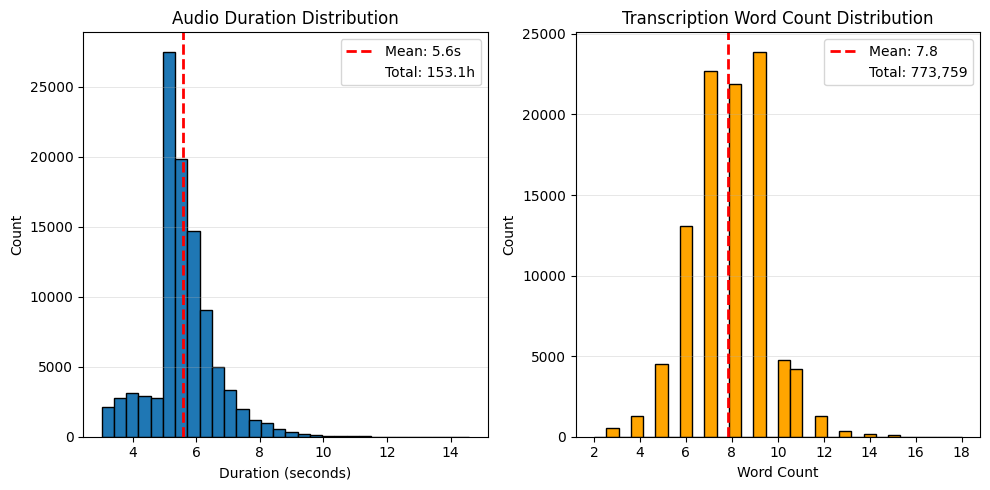

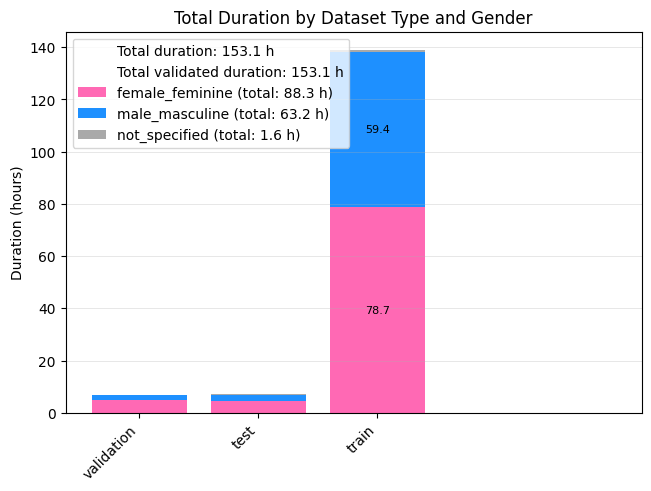

type        accent_region                                     
test        Qoraqalpog'iston                                      20.76
            Farg'ona                                              17.87
            Andijon                                               10.80
            Toshkent shahri                                       10.57
            Samarqand                                              9.14
            Surxondaryo                                            8.07
            Buxoro                                                 6.31
            Toshkent viloyati                                      4.54
            Qashqadaryo                                            3.71
            Toshkent                                               3.44
            Namangan                                               1.71
            Jizzax                                                 1.23
            Xorazm                                                 0.84
 

In [60]:
from scripts.dataset_plotting import plot_distribution_graphs, plot_dataset_type_gender_distribution

plot_distribution_graphs(sampled_df)
plot_dataset_type_gender_distribution(sampled_df)

# Accent region distribution by type
counts = sampled_df.groupby(["type", "accent_region"])["speaker_id"].count()
percentage = (counts / counts.groupby(level=0).sum() * 100).round(2)
percentage = percentage.groupby(level=0, group_keys=False).apply(lambda x: x.sort_values(ascending=False))
print(percentage)

# Age distribution by type
counts = sampled_df.groupby(["type", "age"])["speaker_id"].count()
percentage = (counts / counts.groupby(level=0).sum() * 100).round(2)
percentage = percentage.groupby(level=0, group_keys=False).apply(lambda x: x.sort_values(ascending=False))
print(f"\n{percentage}")

In [61]:
sampled_df.groupby(["type", "gender"])["duration"].sum() / 3600

type        gender         
test        female_feminine     4.52730
            male_masculine      2.24655
            not_specified       0.38803
train       female_feminine    78.67370
            male_masculine     59.39455
            not_specified       0.92609
validation  female_feminine     5.07582
            male_masculine      1.60096
            not_specified       0.26458
Name: duration, dtype: float64

## Part 2

In [4]:
all_data_df = pd.read_csv(ALL_DATA_PATH, index_col="id")
used_paths = set(pd.read_csv(PROCESSED_AUDIO_STATS_PATH)["input_audio_filename"])
unused_data_df = all_data_df[~all_data_df["path"].isin(used_paths)]
print(f"Total available duration: {unused_data_df["duration"].sum() / 3600:.2f} hours")
unused_data_df.describe()

Total available duration: 774.31 hours


,up_votes,down_votes,reported_count,duration,word_count
count,704660.000000,704660.000000,704660.000000,704660.000000,704660.000000
mean,0.703020,0.005300,0.008146,3.955851,6.518938
std,1.704067,0.153148,0.096993,1.035745,1.730202
min,0.000000,0.000000,0.000000,0.216000,1.000000
25%,0.000000,0.000000,0.000000,3.240000,5.000000
50%,0.000000,0.000000,0.000000,3.924000,7.000000
75%,0.000000,0.000000,0.000000,4.536000,8.000000
max,26.000000,19.000000,6.000000,28.152000,19.000000


In [6]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

top_100_speakers = sampled_df["speaker_id"].value_counts(ascending=False).head(100)

In [7]:
val_test_mask = sampled_df["type"].isin(["test", "validation"])
val_test_speakers = set(sampled_df[val_test_mask]["speaker_id"].unique())

top_100_speakers_mask = unused_data_df["speaker_id"].isin(top_100_speakers)

sampled2_df = unused_data_df[(~unused_data_df["speaker_id"].isin(val_test_speakers)) & (~top_100_speakers_mask)]
print(f"Potential total duration: {sampled2_df["duration"].sum() / 3600:.2f} hours")
sampled2_df

Potential total duration: 738.91 hours


,path,speaker_id,accent_region,up_votes,down_votes,reported_count,age,gender,duration,word_count,sentence
id,,,,,,,,,,,
210495,210495.wav,6ff9168d-3398-412b-9510-7caa7628fae1,Farg'ona,0,0,0,18-24,female_feminine,1.908,3,Konsert yaxshi o‘tgan.
210496,210496.wav,e3bf850f-ae4b-424c-ab81-bddbab796b19,Namangan,0,0,0,19-29,female_feminine,3.204,4,Djigan Toshkentda konsert beradi.
210497,210497.wav,6ff9168d-3398-412b-9510-7caa7628fae1,Farg'ona,0,0,0,18-24,female_feminine,2.628,3,"Umuman olganda, qiziqmayman."
210498,210498.wav,348b2776-4432-44e7-868c-8fc11b674509,Toshkent viloyati,2,0,0,< 19,female_feminine,2.196,3,Lekin bolasi bo‘lmaydi.
210499,210499.wav,b2b2ee04-a86b-4ddc-8165-4be7a103fe2f,Jizzax,0,0,0,25-34,male_masculine,2.916,3,"Targ‘ibot qilishdi, tushuntirishdi."
...,...,...,...,...,...,...,...,...,...,...,...
526174,526174.wav,f3955702-ad1f-4896-b1f3-de8d2a5d381a,Jizzax,0,0,0,18-24,female_feminine,4.356,6,Toshkent shahrida alkogoldan zaharlanish holat...
526175,526175.wav,8a393ed4-c4c2-4f5f-8ea2-04401704ca56,Xorazm,0,0,0,18-24,female_feminine,2.808,6,"Agar u qo‘l qo‘ymasa, uni otishadi."
526176,526176.wav,d1f293f7-f89c-4455-91cc-140b0d4ac455,Samarqand,0,0,0,18-24,male_masculine,3.132,6,Voqea yuzasidan tergov ishlari olib borilmoqda.


short_recordings: 
count                                    20000
unique                                    3472
top       646bc419-5171-4da2-b0b4-9bb8cffed055
freq                                        25
Name: speaker_id, dtype: object

medium_recordings: 
count                                    57819
unique                                      68
top       10b29e87-bf01-4b16-bead-a044076f849b
freq                                      2000
Name: speaker_id, dtype: object

long_recordings: 
count                                       78
unique                                      22
top       b2ea482e-0e57-428b-9a25-827582772fd7
freq                                        50
Name: speaker_id, dtype: object


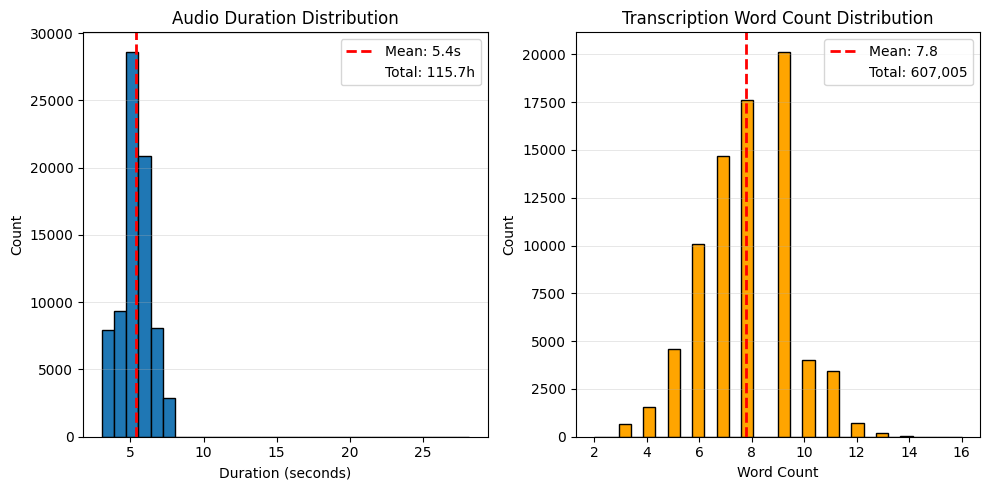

,speaker_id,path,accent_region,up_votes,down_votes,reported_count,age,gender,duration,word_count,sentence,net_votes
id,,,,,,,,,,,,
45,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,45.wav,NaN,4,0,0,NaN,not_specified,4.788,5,Bu voqea yuzaga chiqqaniga ishonolmasdim.,4
92,6697ab93-c99e-4fad-86d8-17d4d28e72c7,92.wav,Toshkent shahri,0,3,3,19-29,male_masculine,3.924,3,Hozirgi ishimizdan mamnunman.,-3
123,eecc8201-90e7-4fe9-9875-0d0e15246047,123.wav,Toshkent shahri,5,0,0,50-59,female_feminine,3.096,3,Haqiqiy fransuzcha ekler.,5
124,eecc8201-90e7-4fe9-9875-0d0e15246047,124.wav,Toshkent shahri,4,0,0,50-59,female_feminine,3.852,4,O‘zbekistonlik mashhurlarning bolaligi .,4
129,eecc8201-90e7-4fe9-9875-0d0e15246047,129.wav,Toshkent shahri,5,0,0,50-59,female_feminine,3.996,3,“O‘qituvchilardan ko‘nglim qoldi.,5
...,...,...,...,...,...,...,...,...,...,...,...,...
864842,17bbf3ac-0132-4bfd-a249-caa0c0041b96,864842.wav,Xorazm,0,0,0,19-29,female_feminine,3.816,6,Tolibon Mozori Sharifda Ahmad Shohni o‘ldirgan\r,0
864850,9c21cf31-0a8a-446c-b76a-3ff5a0fdf0ac,864850.wav,Surxondaryo,0,0,0,19-29,male_masculine,15.480,11,"Xususiy mulk daxlsizligini, tadbirkorlikni qo‘...",0
864852,149376f3-e6dc-4996-819e-3a0b9857e535,864852.wav,Farg'ona,0,0,0,18-24,female_feminine,4.392,4,Keyinchaliktanlagan kasbimdan hursand bo‘lgan.\r,0


In [8]:
from scripts.dataset_plotting import plot_distribution_graphs

# Sort by speaker_id for deterministic groupby order
sampled2_df = sampled2_df.sort_values("speaker_id")

short_audios = (sampled2_df["duration"] >= 3) & (sampled2_df["duration"] < 5)
medium_audios = (sampled2_df["duration"] >= 5) & (sampled2_df["duration"] < 8)
long_audios = (sampled2_df["duration"] >= 8) & (sampled2_df["duration"] < 30)

short_samples = (
    sampled2_df[short_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 30), random_state=SEED),
           include_groups=False)  # Maximum up to 30 recordings per speaker
    .reset_index(level=0)
).sample(20_000, weights="duration", random_state=SEED)
print(f"short_recordings: \n{short_samples["speaker_id"].describe()}")

medium_samples = (
    sampled2_df[medium_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 2000), random_state=SEED),
           include_groups=False)  # Maximum up to 2000 recordings per speaker
    .reset_index(level=0)
)
print(f"\nmedium_recordings: \n{medium_samples["speaker_id"].describe()}")

long_samples = (
    sampled2_df[long_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 700), random_state=SEED),
           include_groups=False)  # Maximum up to 700 recordings per speaker
    .reset_index(level=0)
)
print(f"\nlong_recordings: \n{long_samples["speaker_id"].describe()}")

sampled2_df = pd.concat([short_samples, medium_samples, long_samples]).sort_index()

# Remove recordings with net_votes <= -5 (up_votes - down_votes)
sampled2_df.loc[:, "net_votes"] = sampled2_df["up_votes"] - sampled2_df["down_votes"]
majority_down_voted_mask = sampled2_df["net_votes"] <= -5
sampled2_df = sampled2_df[~majority_down_voted_mask]

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")

plot_distribution_graphs(sampled2_df)

sampled2_df

In [19]:
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

processed_audio_stats_df = extract_and_normalize_audio_from_parquet(sampled2_df["path"].tolist())
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS2_PATH, index=False)

processed_audio_stats_df

Need to extract 31820 audio files
Found 33 parquet files. Started processing...



Processing files: 100%|██████████| 33/33 [06:59<00:00, 12.72s/it]



Extracted and normalized 31820 audio files to ../datasets/uzbekvoice_dataset/data/sampled_audio


,input_audio_filename,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude,is_clipped
0,210533.mp3,-19.4680,-23.1278,3.024,3.024,0.0,0.5588,False
1,210564.mp3,-21.7213,-23.3177,3.204,3.204,0.0,0.6726,False
2,210643.mp3,-17.8002,-23.1321,3.420,3.420,0.0,0.4964,False
3,210688.mp3,-16.4370,-23.1265,3.276,3.276,0.0,0.4036,False
4,210716.mp3,-14.2168,-23.0844,3.204,3.204,0.0,0.3487,False
...,...,...,...,...,...,...,...,...
31815,525364.mp3,-20.0950,-23.1310,5.256,5.256,0.0,0.5817,False
31816,525640.mp3,-16.4848,-23.1668,3.600,3.600,0.0,0.4204,False
31817,525648.mp3,-15.5726,-23.1131,5.076,5.076,0.0,0.4004,False
31818,525997.mp3,-19.1406,-23.1789,5.508,5.508,0.0,0.5511,False


In [21]:
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")
processed_audio_stats_df = pd.read_csv(PROCESSED_AUDIO_STATS2_PATH)
processed_audio_stats_df["input_audio_filename"].str.replace(".mp3", ".wav", regex=False)

old_total_duration = sampled2_df["duration"].sum() / 3600
old_duration_mean = sampled2_df["duration"].mean()

# --- Replace sampled2_df.duration using processed_audio_stats_df.final_duration ---

# Merge final_duration into the sampled dataframe
sampled2_df = sampled2_df.merge(
    processed_audio_stats_df[["input_audio_filename", "final_duration"]],
    how="left",
    left_on="path",
    right_on="input_audio_filename"
)

# Replace duration only where we have final_duration (non-null values)
sampled2_df["duration"] = sampled2_df["final_duration"].fillna(sampled2_df["duration"])

# Drop helper columns
sampled2_df = sampled2_df.drop(columns=["final_duration"])

# --- Remove suspiciously short and short recordings  ---

# Remove very short audios
mask_short_audio = (processed_audio_stats_df["final_duration"] < 3)
paths_to_remove = processed_audio_stats_df.loc[mask_short_audio, "input_audio_filename"].tolist()

total_reduced_duration = processed_audio_stats_df["reduced_duration"].sum() / 3600

# Remove these recordings entirely
sampled2_df = sampled2_df[
    ~sampled2_df["path"].isin(paths_to_remove)
]
print(f"{len(paths_to_remove)} recordings are removed from the sample")

# Updated totals
current_total_duration = sampled2_df["duration"].sum() / 3600
current_duration_mean = sampled2_df["duration"].mean()

# Save updated CSVs
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS2_PATH, index=False)
sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")

print(
    f"Before audio preprocessing: total duration - {old_total_duration:,.3f} h | mean {old_duration_mean:,.1f} s"
)
print(
    f"After audio preprocessing: total duration - {current_total_duration:,.3f} h "
    f"(reduced {total_reduced_duration * 60:.0f} min) | mean {current_duration_mean:,.1f} s"
)

sampled2_df

8 recordings are removed from the sample
Before audio preprocessing: total duration - 115.721 h | mean 5.4 s
After audio preprocessing: total duration - 115.721 h (reduced 22 min) | mean 5.4 s


,speaker_id,path,accent_region,up_votes,down_votes,reported_count,age,gender,duration,word_count,sentence,net_votes,input_audio_filename
0,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,45.wav,NaN,4,0,0,NaN,not_specified,4.788,5,Bu voqea yuzaga chiqqaniga ishonolmasdim.,4,NaN
1,6697ab93-c99e-4fad-86d8-17d4d28e72c7,92.wav,Toshkent shahri,0,3,3,19-29,male_masculine,3.924,3,Hozirgi ishimizdan mamnunman.,-3,NaN
2,eecc8201-90e7-4fe9-9875-0d0e15246047,123.wav,Toshkent shahri,5,0,0,50-59,female_feminine,3.096,3,Haqiqiy fransuzcha ekler.,5,NaN
3,eecc8201-90e7-4fe9-9875-0d0e15246047,124.wav,Toshkent shahri,4,0,0,50-59,female_feminine,3.852,4,O‘zbekistonlik mashhurlarning bolaligi .,4,NaN
4,eecc8201-90e7-4fe9-9875-0d0e15246047,129.wav,Toshkent shahri,5,0,0,50-59,female_feminine,3.996,3,“O‘qituvchilardan ko‘nglim qoldi.,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77803,17bbf3ac-0132-4bfd-a249-caa0c0041b96,864842.wav,Xorazm,0,0,0,19-29,female_feminine,3.816,6,Tolibon Mozori Sharifda Ahmad Shohni o‘ldirgan\r,0,NaN
77804,9c21cf31-0a8a-446c-b76a-3ff5a0fdf0ac,864850.wav,Surxondaryo,0,0,0,19-29,male_masculine,15.480,11,"Xususiy mulk daxlsizligini, tadbirkorlikni qo‘...",0,NaN
77805,149376f3-e6dc-4996-819e-3a0b9857e535,864852.wav,Farg'ona,0,0,0,18-24,female_feminine,4.392,4,Keyinchaliktanlagan kasbimdan hursand bo‘lgan.\r,0,NaN
77806,140b19c0-9bc6-462d-a621-a6653d509947,864871.wav,Andijon,0,0,0,19-29,male_masculine,3.816,8,"Tolani bir yoqli etadi, chigitni bir yoqli eta...",0,NaN


In [24]:
# Before running set your own PROJECT_ID to .env file (e.g. GOOGLE_CLOUD_PROJECT="your id here")
from pathlib import Path
from scripts import google_transcribe

# Configuration
CHECKPOINT_INTERVAL = 1000  # Save every 1000 audio files
CHECKPOINT_PATH = "transcription_checkpoint.csv"

sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

# Prepare audio paths
audio_paths = sampled2_df["path"].apply(
    lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name)
).tolist()

# Check for existing checkpoint
existing_results = []
processed_paths = set()

if os.path.exists(CHECKPOINT_PATH):
    print(f"Found existing checkpoint: {CHECKPOINT_PATH}")
    checkpoint_df = pd.read_csv(CHECKPOINT_PATH)
    existing_results = checkpoint_df.to_dict('records')
    processed_paths = set(checkpoint_df["path"].apply(lambda x: Path(x).name))
    print(f"Resuming from checkpoint with {len(existing_results)} already processed files")

    # Filter out already processed files
    audio_paths = [
        path for path in audio_paths
        if Path(path).name not in processed_paths
    ]
    print(f"Remaining files to process: {len(audio_paths)}")

# Process files in parallel using two regions
print(f"\nProcessing {len(audio_paths)} audio files using 2 regions (eu, us)...")
print("Starting parallel transcription with checkpoint saving...\n")


def save_checkpoint(results_list, is_final=False):
    """Save current results to checkpoint file"""
    df = pd.DataFrame(results_list)
    df.to_csv(CHECKPOINT_PATH, index_label="id")
    status = "FINAL" if is_final else "CHECKPOINT"
    print(f"\n[{status}] Saved {len(results_list)} results to: {CHECKPOINT_PATH}")


try:
    # Start with existing results
    all_results = existing_results.copy()

    # Process remaining files
    if audio_paths:
        results = google_transcribe.transcribe_batch_parallel(
            audio_paths=audio_paths,
            regions=["eu", "us"],
            max_workers=20,
            checkpoint_callback=lambda new_results: save_checkpoint(all_results + new_results),
            checkpoint_interval=CHECKPOINT_INTERVAL
        )
        all_results.extend(results)

    # Save final results
    save_checkpoint(all_results, is_final=True)

except KeyboardInterrupt:
    print("\n\n⚠️  Process interrupted by user!")
    print(f"Partial results saved to checkpoint: {CHECKPOINT_PATH}")
    print("You can resume by running this script again.")
    raise
except Exception as err:
    print(f"\n❌ Critical error during parallel processing: {type(err).__name__}: {err}")
    print(f"Partial results saved to checkpoint: {CHECKPOINT_PATH}")
    raise

# Process final results
predicted_transcriptions = []
failed_count = 0
success_count = 0

for result in all_results:
    transcription_entry = {
        "path": Path(result["path"]).name,
        "predicted_sentence": result["predicted_sentence"],
        "error_message": result["error_message"],
        "error_type": result["error_type"],
    }

    predicted_transcriptions.append(transcription_entry)

    if result["predicted_sentence"] is not None:
        success_count += 1
    else:
        failed_count += 1

# Save final results to the main output file
predicted_transcripts_df = pd.DataFrame(predicted_transcriptions)
predicted_transcripts_df.to_csv(TRANSCRIPTION_RESULTS2_PATH, index_label="id")
print(f"\n✓ Saved final transcription results to: {TRANSCRIPTION_RESULTS2_PATH}")

# Clean up checkpoint file
if os.path.exists(CHECKPOINT_PATH):
    os.remove(CHECKPOINT_PATH)
    print(f"✓ Removed checkpoint file: {CHECKPOINT_PATH}")

print(f"\n{'=' * 60}")
print(f"Transcription Complete!")
print(f"{'=' * 60}")
print(f"✓ Successfully transcribed: {success_count}")
print(f"✗ Failed: {failed_count}")
print(f"Success rate: {success_count / len(sampled2_df) * 100:.2f}%")

predicted_transcripts_df


Processing 15765 audio files using 2 regions (eu, us)...
Starting parallel transcription with checkpoint saving...

Using 2 project(s) across 2 region(s)
Total combinations: 4


Transcribing:   6%|▋         | 1000/15765 [01:47<31:42,  7.76file/s]


[CHECKPOINT] Saved 1000 results to: transcription_checkpoint.csv


Transcribing:  13%|█▎        | 2003/15765 [03:37<22:06, 10.37file/s]


[CHECKPOINT] Saved 2000 results to: transcription_checkpoint.csv


Transcribing:  19%|█▉        | 3002/15765 [05:26<17:14, 12.34file/s]


[CHECKPOINT] Saved 3000 results to: transcription_checkpoint.csv


Transcribing:  25%|██▌       | 4004/15765 [07:23<17:49, 11.00file/s]


[CHECKPOINT] Saved 4000 results to: transcription_checkpoint.csv


Transcribing:  32%|███▏      | 5002/15765 [09:19<16:34, 10.82file/s]


[CHECKPOINT] Saved 5000 results to: transcription_checkpoint.csv


Transcribing:  38%|███▊      | 6003/15765 [11:08<12:22, 13.15file/s]


[CHECKPOINT] Saved 6000 results to: transcription_checkpoint.csv


Transcribing:  44%|████▍     | 7001/15765 [12:56<16:13,  9.00file/s]


[CHECKPOINT] Saved 7000 results to: transcription_checkpoint.csv


Transcribing:  51%|█████     | 8002/15765 [15:13<11:25, 11.33file/s]


[CHECKPOINT] Saved 8000 results to: transcription_checkpoint.csv


Transcribing:  57%|█████▋    | 9002/15765 [17:31<12:25,  9.07file/s]


[CHECKPOINT] Saved 9000 results to: transcription_checkpoint.csv


Transcribing:  63%|██████▎   | 10002/15765 [19:55<08:20, 11.52file/s]


[CHECKPOINT] Saved 10000 results to: transcription_checkpoint.csv


Transcribing:  70%|██████▉   | 10999/15765 [22:21<10:55,  7.27file/s]  


[CHECKPOINT] Saved 11000 results to: transcription_checkpoint.csv


Transcribing:  76%|███████▌  | 12002/15765 [24:25<06:36,  9.49file/s]


[CHECKPOINT] Saved 12000 results to: transcription_checkpoint.csv


Transcribing:  82%|████████▏ | 13002/15765 [26:38<05:58,  7.71file/s]


[CHECKPOINT] Saved 13000 results to: transcription_checkpoint.csv


Transcribing:  89%|████████▉ | 13998/15765 [28:55<03:15,  9.04file/s]


[CHECKPOINT] Saved 14000 results to: transcription_checkpoint.csv


Transcribing:  95%|█████████▌| 15001/15765 [31:19<01:39,  7.65file/s]


[CHECKPOINT] Saved 15000 results to: transcription_checkpoint.csv


Transcribing: 100%|██████████| 15765/15765 [37:03<00:00,  7.09file/s]


[CHECKPOINT] Saved 15765 results to: transcription_checkpoint.csv

[FINAL] Saved 15765 results to: transcription_checkpoint.csv

✓ Saved final transcription results to: ../datasets/uzbekvoice_dataset/data/google_spt_transcriptions2_new.csv
✓ Removed checkpoint file: transcription_checkpoint.csv

Transcription Complete!
✓ Successfully transcribed: 15764
✗ Failed: 1
Success rate: 99.99%


,path,predicted_sentence,error_message,error_type
0,504.wav,yumshoq yuvish ikki,None,None
1,496.wav,foto galereya fotobombali suratlar,None,None
2,315.wav,identifikatsiya raqami 1091,None,None
3,642.wav,Hozir nimaga egamiz?,None,None
4,460.wav,Provansda ittifoqchilar marosimi,None,None
...,...,...,...,...
15760,864734.wav,Ipak qurti urug'i importiga chek qo'yildi.,None,None
15761,864810.wav,Dunyodagi eng boy odam o'lmas startapga sarmoy...,None,None
15762,864828.wav,Finlandiya vazirligidan ta'lim o'rgatilgan.,None,None
15763,864852.wav,Keyinchalik tanlagan kasbimdan xursand bo'lgan.,None,None


In [26]:
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")
predicted_transcripts_df = pd.read_csv(TRANSCRIPTION_RESULTS2_PATH, index_col="id")

print(predicted_transcripts_df.info())

# Merge transcription results with original data
sampled2_df = sampled2_df.merge(
    predicted_transcripts_df,
    left_on="path",
    right_on="path",
    how="left"
)

sampled2_df.drop(columns=["error_message", "error_type", "input_audio_filename"], inplace=True, errors="ignore")
sampled2_df.rename(columns={"sentence": "text_original", "predicted_sentence": "text_spt"}, inplace=True)

# Reorder columns
cols = list(sampled2_df.columns)
cols.remove("net_votes")
cols.remove("text_original")
cols.insert(5, "net_votes")
cols.insert(-1, "text_original")
sampled2_df = sampled2_df[cols]

sampled2_df

<class 'pandas.core.frame.DataFrame'>
Index: 77808 entries, 0 to 77807
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   path                77808 non-null  object
 1   predicted_sentence  77662 non-null  object
 2   error_message       2 non-null      object
 3   error_type          2 non-null      object
dtypes: object(4)
memory usage: 3.0+ MB
None


,speaker_id,path,accent_region,up_votes,down_votes,net_votes,reported_count,age,gender,duration,word_count,input_audio_filename,text_original,text_spt
0,38486d7f-0cdc-43d8-8c04-bcdbf525bbd6,45.wav,NaN,4,0,4,0,NaN,not_specified,4.788,5,NaN,Bu voqea yuzaga chiqqaniga ishonolmasdim.,Bu voqea yuzaga chiqqaniga ishonolmas edim.
1,6697ab93-c99e-4fad-86d8-17d4d28e72c7,92.wav,Toshkent shahri,0,3,-3,3,19-29,male_masculine,3.924,3,NaN,Hozirgi ishimizdan mamnunman.,NaN
2,eecc8201-90e7-4fe9-9875-0d0e15246047,123.wav,Toshkent shahri,5,0,5,0,50-59,female_feminine,3.096,3,NaN,Haqiqiy fransuzcha ekler.,haqiqiy fransuzcha ekler
3,eecc8201-90e7-4fe9-9875-0d0e15246047,124.wav,Toshkent shahri,4,0,4,0,50-59,female_feminine,3.852,4,NaN,O‘zbekistonlik mashhurlarning bolaligi .,O'zbekistonlik mashhurlarning bolaligi
4,eecc8201-90e7-4fe9-9875-0d0e15246047,129.wav,Toshkent shahri,5,0,5,0,50-59,female_feminine,3.996,3,NaN,“O‘qituvchilardan ko‘nglim qoldi.,O'qituvchilardan ko'nglim qoldi.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77803,17bbf3ac-0132-4bfd-a249-caa0c0041b96,864842.wav,Xorazm,0,0,0,0,19-29,female_feminine,3.816,6,NaN,Tolibon Mozori Sharifda Ahmad Shohni o‘ldirgan\r,Tolibon Mozori Sharifda Ahmad shohni o'ldirgan.
77804,9c21cf31-0a8a-446c-b76a-3ff5a0fdf0ac,864850.wav,Surxondaryo,0,0,0,0,19-29,male_masculine,15.480,11,NaN,"Xususiy mulk daxlsizligini, tadbirkorlikni qo‘...","Xususiy mulk daxlsizligini, tadbirkorlikni qo'..."
77805,149376f3-e6dc-4996-819e-3a0b9857e535,864852.wav,Farg'ona,0,0,0,0,18-24,female_feminine,4.392,4,NaN,Keyinchaliktanlagan kasbimdan hursand bo‘lgan.\r,Keyinchalik tanlagan kasbimdan xursand bo'lgan.
77806,140b19c0-9bc6-462d-a621-a6653d509947,864871.wav,Andijon,0,0,0,0,19-29,male_masculine,3.816,8,NaN,"Tolani bir yoqli etadi, chigitni bir yoqli eta...","Tog'larni bir yoqli etadi, chigitni bir yoqli ..."


In [27]:
# Check if it contains number in digits and number in words (136 000 - bir yuz o'ttiz olti ming)
pattern = r"^(\d+(?: \d{3})*) - [\w| |']+$"
mask = sampled2_df["text_original"].str.contains(pattern, regex=True, na=False)

print(f"Affected number of rows: {len(sampled2_df[mask])}")
print("\nRandom 5 rows that matches the pattern:")
matched_5_rows = sampled2_df[mask][["path", "text_original", "text_spt"]].sample(5)

sampled2_df.loc[mask, "text_original"] = sampled2_df.loc[mask, "text_original"].str.extract(pattern, expand=False)
matched_5_rows

Affected number of rows: 142

Random 5 rows that matches the pattern:


/tmp/ipykernel_679725/2554421636.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = sampled2_df["text_original"].str.contains(pattern, regex=True, na=False)


,path,text_original,text_spt
77401,857082.wav,31 030 - o'ttiz bir ming o'ttiz,31 030
77354,856399.wav,200 133 - ikki yuz ming bir yuz o'ttiz uch,200 133
77417,857169.wav,15 995 - o'n besh ming to'qqiz yuz to'qson besh,15 995
77368,856579.wav,4 117 365 - to'rt million bir yuz o'n yetti mi...,4 117 365
77327,856121.wav,829 013 - sakkiz yuz yigirma to'qqiz ming o'n uch,2029 0 13


In [29]:
# import scripts.similarity_metrics as similarity_metrics
import scripts.similarity_metrics as similarity_metrics

# Apply similarity metrics to each row
metrics = sampled2_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["text_original"],
        hypothesis=row["text_spt"],  # Google SPT generated text
    ),
    axis=1
)

# Convert list of dicts → DataFrame
metrics_df = pd.DataFrame(metrics.tolist())

# Merge metric columns back into main DataFrame and save
sampled2_df: pd.DataFrame = pd.concat([sampled2_df, metrics_df], axis=1)

sampled2_df.sort_values("wer", ascending=False)

,speaker_id,path,accent_region,up_votes,down_votes,net_votes,reported_count,age,gender,duration,...,input_audio_filename,text_original,text_spt,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
19368,603b95fa-f399-4e44-b8a8-d637e42c32f1,294180.wav,Jizzax,0,0,0,0,18-24,male_masculine,5.328,...,NaN,Britaniyaning oshpazlik yo‘nalishidagi yozuvch...,"Bir qani, boshqa yozuvchilarning kelgan yozuvc...",britaniyaning oshpazlik yo'nalishidagi yozuvch...,bir qani boshqa yozuvchilarning kelgan yozuvch...,762.0000,772.0735,0.0002,6,4572
11182,b2ea482e-0e57-428b-9a25-827582772fd7,138519.wav,Sirdaryo,0,0,0,0,25-34,male_masculine,18.072,...,NaN,"Qariya Shenks aytganidek, bu hayot-mamot masal...","Qarish, shishish, shishish, shishish, shishish...",qariya shenks aytganidek bu hayot-mamot masalasi,qarish shishish shishish shishish shishish shi...,422.6667,475.0833,0.0003,6,2536
20636,231d3776-2dbe-4a42-a535-c67943427e3f,321620.wav,Qoraqalpog'iston,0,0,0,0,18-24,female_feminine,5.472,...,NaN,"Yugurgilar buzib olamni, Ko‘zim nuri bolajonla...",yuz yuz yuz yuz yuz yuz yuz yuz yuz yuz yuz yu...,yugurgilar buzib olamni ko'zim nuri bolajonlarim,yuz yuz yuz yuz yuz yuz yuz yuz yuz yuz yuz yu...,307.1667,153.3125,0.0005,6,1843
11177,b2ea482e-0e57-428b-9a25-827582772fd7,138475.wav,Sirdaryo,0,0,0,0,25-34,male_masculine,16.992,...,NaN,"O‘sha gapirayotgan odamlar maddoh deydi, pulga...","O'sha gap bilan, keyingi gapim bilan, mana bu ...",o'sha gapirayotgan odamlar maddoh deydi pulga ...,o'sha gap bilan keyingi gapim bilan mana bu ma...,166.2857,115.6769,0.0073,7,1166
30283,82cdab0f-b903-4cca-82aa-11247c5eb17a,394440.wav,Samarqand,0,0,0,0,18-24,male_masculine,5.760,...,NaN,Xitoy bahsli orollarga raketa qurilmalarini ma...,Xitoy va Xitoy va Xitoy va Xitoy va Xitoy va X...,xitoy bahsli orollarga raketa qurilmalarini ma...,xitoy va xitoy va xitoy va xitoy va xitoy va x...,165.1250,84.4143,0.0020,8,1322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43959,2a815774-e953-4031-931a-8a28052e5cf9,473183.wav,Andijon,0,0,0,0,18-24,female_feminine,5.040,...,NaN,Tojikiston huquqni muhofaza qilish organlari R...,Tojikiston huquqni muhofaza qilish organlari R...,tojikiston huquqni muhofaza qilish organlari r...,tojikiston huquqni muhofaza qilish organlari r...,0.0000,0.0000,1.0000,9,9
44009,8a393ed4-c4c2-4f5f-8ea2-04401704ca56,473517.wav,Xorazm,2,0,2,0,18-24,female_feminine,5.796,...,NaN,Shu tariqa Jazoir musobaqaning chorak finali y...,Shu tariqa Jazoir musobaqaning chorak finali y...,shu tariqa jazoir musobaqaning chorak finali y...,shu tariqa jazoir musobaqaning chorak finali y...,0.0000,0.0000,1.0000,9,9
44011,56ac8e86-b8c9-4879-a342-0eeb94f686fc,473525.wav,Qashqadaryo,0,0,0,0,< 19,female_feminine,5.220,...,NaN,Ilk dala mavsumidayoq u yerdan devoriy suratla...,Ilk dala mavsumidayoq u yerdan devoriy suratla...,ilk dala mavsumidayoq u yerdan devoriy suratla...,ilk dala mavsumidayoq u yerdan devoriy suratla...,0.0000,0.0000,1.0000,9,9
44012,e2716f95-70b5-4832-b903-eef2343591a4,473527.wav,Surxondaryo,0,0,0,0,18-24,male_masculine,5.364,...,NaN,"Buni omadsizlik, ishonchsizlik va yana nimalar...","Buni omadsizlik, ishonchsizlik va yana nimalar...",buni omadsizlik ishonchsizlik va yana nimalard...,buni omadsizlik ishonchsizlik va yana nimalard...,0.0000,0.0000,1.0000,9,9


In [30]:
duration_with_high_wer = sampled2_df[sampled2_df["wer"] >= 1.0]["duration"].sum() / 3600
estimated_original_wer = sampled2_df[sampled2_df["wer"] < 1.0]["wer"].mean()
print(
    f"Estimated rough WER: {estimated_original_wer * 100:.2f}% (after removing WER >= 100%, amounting {duration_with_high_wer:.2f} hours)")

Estimated rough WER: 9.08% (after removing WER >= 100%, amounting 0.75 hours)


In [31]:
aligned_mask = sampled2_df["wer"] == 0.0

total_recordings = len(sampled2_df)
not_aligned_duration = sampled2_df[~aligned_mask]["duration"].sum() / 3600

len_aligned_recordings = len(sampled2_df[aligned_mask])
aligned_duration = sampled2_df[aligned_mask]["duration"].sum() / 3600

print(f"Total duration of the sample: {sampled2_df["duration"].sum() / 3600:.2f} hours")
print(
    f"Audio and transcription aligned recordings: {len_aligned_recordings:,} - {aligned_duration:.2f} hours")
print(
    f"Remaining recordings: {total_recordings - len_aligned_recordings:,} - {not_aligned_duration:.2f} hours")

print("\nFinal sample after removing mis-aligned recordings:")

# Remove poor alignment (wer > 0%)
sampled2_df = sampled2_df[aligned_mask]

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")
sampled2_df.describe()

Total duration of the sample: 115.72 hours
Audio and transcription aligned recordings: 46,068 - 67.35 hours
Remaining recordings: 31,740 - 48.38 hours

Final sample after removing mis-aligned recordings:


,up_votes,down_votes,net_votes,reported_count,duration,word_count,input_audio_filename,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,46068.000000,46068.000000,46068.000000,46068.000000,46068.000000,46068.000000,0.0,46068.0,46068.0,46068.0,46068.000000,46068.000000
mean,0.712968,0.000760,0.712208,0.005014,5.262760,7.714314,NaN,0.0,0.0,1.0,7.659417,7.659417
std,1.761433,0.041925,1.762239,0.071854,1.019496,1.695560,NaN,0.0,0.0,0.0,1.673091,1.673091
min,0.000000,0.000000,-4.000000,0.000000,3.024000,2.000000,NaN,0.0,0.0,1.0,2.000000,2.000000
25%,0.000000,0.000000,0.000000,0.000000,4.716000,7.000000,NaN,0.0,0.0,1.0,7.000000,7.000000
50%,0.000000,0.000000,0.000000,0.000000,5.328000,8.000000,NaN,0.0,0.0,1.0,8.000000,8.000000
75%,0.000000,0.000000,0.000000,0.000000,5.868000,9.000000,NaN,0.0,0.0,1.0,9.000000,9.000000
max,26.000000,4.000000,26.000000,2.000000,26.784000,16.000000,NaN,0.0,0.0,1.0,14.000000,14.000000


In [32]:
import glob

sampled1_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

sampled_audios1 = set(sampled1_df["path"])
sampled_audios2 = set(sampled2_df["path"])
all_audio_paths_sampled = sampled_audios1.union(sampled_audios2)

all_audio_paths_available = set(
    map(lambda full_path: Path(full_path).name, glob.glob(os.path.join(SAMPLED_AUDIO_DIR, "*.wav")))
)

missing_audio_paths = all_audio_paths_sampled - all_audio_paths_available
audio_paths_to_remove = all_audio_paths_available - all_audio_paths_sampled

extract_and_normalize_audio_from_parquet(missing_audio_paths)

for filename in audio_paths_to_remove:
    path = os.path.join(SAMPLED_AUDIO_DIR, filename)
    os.remove(path)

print(f"Removed unnecessary {len(audio_paths_to_remove):,} audio files")

Need to extract 0 audio files
Found 33 parquet files. Started processing...



Processing files:   0%|          | 0/33 [00:00<?, ?it/s]


Extracted and normalized 0 audio files to ../datasets/uzbekvoice_dataset/data/sampled_audio


Removed unnecessary 126,923 audio files


In [37]:
sampled1_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

sampled2_df["type"] = "train"
sampled2_df.fillna({"gender": "Unknown"}, inplace=True)

val_test_df = sampled1_df[sampled1_df["type"].isin(["validation", "test"])]

sampled2_df = pd.concat([sampled2_df, val_test_df], ignore_index=True)
sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")

train_speakers = set(sampled2_df.query("type == 'train'")["speaker_id"].unique())
val_speakers = set(sampled2_df.query("type == 'validation'")["speaker_id"].unique())
test_speakers = set(sampled2_df.query("type == 'test'")["speaker_id"].unique())

# Verify no speaker overlap
print(f"\nUnique speakers - Train: {len(train_speakers)}")
print(f"Unique speakers - Validation: {len(val_speakers)}")
print(f"Unique speakers - Test: {len(test_speakers)}")

print(f"\nOverlap Train/Val: {len(train_speakers.intersection(val_speakers))}")
print(f"Overlap Train/Test: {len(train_speakers.intersection(test_speakers))}")
print(f"Overlap Val/Test: {len(val_speakers.intersection(test_speakers))}")

duration_by_type = sampled2_df.groupby("type")["duration"].sum() / 3600
print("\nDuration by type (hours):")
duration_by_type.sort_values(ascending=False)


Unique speakers - Train: 3004
Unique speakers - Validation: 246
Unique speakers - Test: 222

Overlap Train/Val: 0
Overlap Train/Test: 0
Overlap Val/Test: 0

Duration by type (hours):


type
train         67.34578
test           7.16188
validation     6.94136
Name: duration, dtype: float64

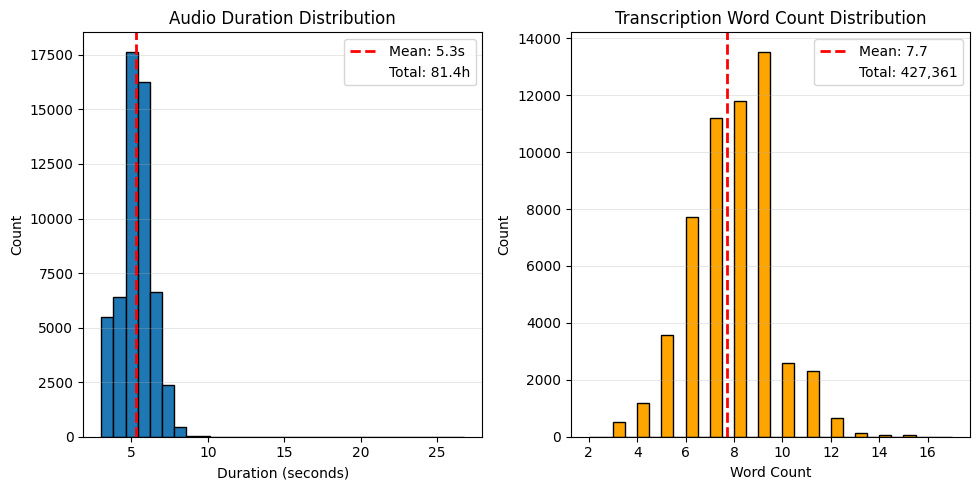

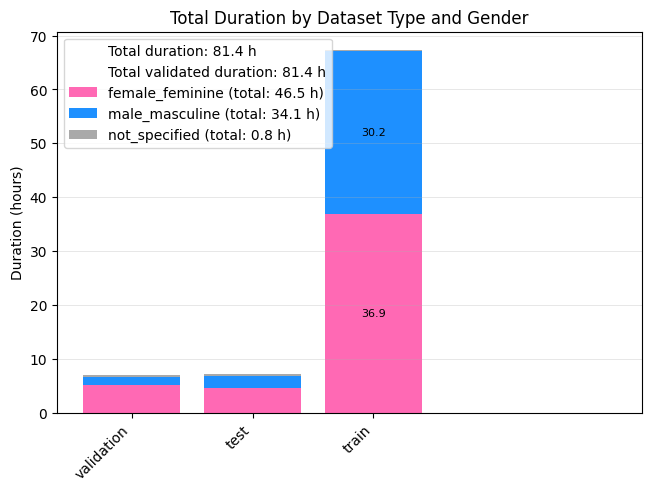

type        accent_region                                     
test        Qoraqalpog'iston                                      20.76
            Farg'ona                                              17.87
            Andijon                                               10.80
            Toshkent shahri                                       10.57
            Samarqand                                              9.14
            Surxondaryo                                            8.07
            Buxoro                                                 6.31
            Toshkent viloyati                                      4.54
            Qashqadaryo                                            3.71
            Toshkent                                               3.44
            Namangan                                               1.71
            Jizzax                                                 1.23
            Xorazm                                                 0.84
 

In [38]:
from scripts.dataset_plotting import plot_distribution_graphs, plot_dataset_type_gender_distribution

plot_distribution_graphs(sampled2_df)
plot_dataset_type_gender_distribution(sampled2_df)

# Accent region distribution by type
counts = sampled2_df.groupby(["type", "accent_region"])["speaker_id"].count()
percentage = (counts / counts.groupby(level=0).sum() * 100).round(2)
percentage = percentage.groupby(level=0, group_keys=False).apply(lambda x: x.sort_values(ascending=False))
print(percentage)

# Age distribution by type
counts = sampled2_df.groupby(["type", "age"])["speaker_id"].count()
percentage = (counts / counts.groupby(level=0).sum() * 100).round(2)
percentage = percentage.groupby(level=0, group_keys=False).apply(lambda x: x.sort_values(ascending=False))
print(f"\n{percentage}")

In [52]:
sampled1_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

val_test_mask = sampled1_df["type"].isin(["test", "validation"])
val_test_speakers = set(sampled1_df[val_test_mask]["speaker_id"].unique())
not_val_test_speaker_mask = ~sampled1_df["speaker_id"].isin(val_test_speakers)

top_100_speakers = sampled1_df[not_val_test_speaker_mask]["speaker_id"].value_counts(ascending=False).head(100)
last_12_top_speakers = set(top_100_speakers.tail(12).index)
mask = sampled1_df["speaker_id"].isin(last_12_top_speakers)

total_duration = sampled1_df[mask]["duration"].sum() / 3600
print(f"Total duration among chosen top speakers: {total_duration:.2f} hours")
print(f"Will be used for augmentation")

(sampled1_df[mask].groupby(["speaker_id", "gender"])["duration"].sum() / 3600).sort_values(ascending=False)

Total duration among chosen top speakers: 4.10 hours
Will be used for augmentation


speaker_id                            gender         
2f22150b-721c-4dc6-b2dd-ad02e453bceb  female_feminine    0.39555
ce7fe857-d368-48e7-9dcb-b107aa0d1572  female_feminine    0.39309
ce811c72-cf6c-4a49-8572-fd63d3647df5  male_masculine     0.38439
14406f8e-1b54-4e2b-b519-0d3550fe1220  male_masculine     0.37362
f10bd781-1de6-4f23-a821-6c7d7f26812f  female_feminine    0.34494
aea4240a-cbc1-40ee-a211-aa8ff42fefde  female_feminine    0.33184
2623a10e-2a98-4d25-873c-996024564e58  female_feminine    0.33022
f20972c1-143d-4446-86d6-623787d894bc  female_feminine    0.31857
c908697e-0136-4a92-9260-ec92b3beb97d  female_feminine    0.31028
6f949ed8-655b-489b-bb09-fd9f2cd219b1  male_masculine     0.30891
b571a321-ca43-4ea0-b080-6d2254fef526  male_masculine     0.30886
ebd9bf57-b23b-4fab-b8e2-f5d07e3eb7c5  female_feminine    0.29626
Name: duration, dtype: float64

In [53]:
from scripts.audio_augmentation import augment_dataset, AugmentationType

mask = sampled1_df["speaker_id"].isin(last_12_top_speakers)
previous_sample_to_augment = sampled1_df[mask]
previous_sample_to_augment["type"] = "train"

audio_paths = previous_sample_to_augment["path"].apply(
    lambda filename: os.path.join(SAMPLED_AUDIO_DIR, filename)).tolist()

augmentation_types = [
    AugmentationType.SPEED | AugmentationType.NOISE,
    AugmentationType.PITCH | AugmentationType.TIME_MASK,
]

augmentation_df = augment_dataset(
    audio_paths,
    SAMPLED_AUDIO_DIR,
    augmentation_types,
    noise_prob=0.7,
    time_mask_prob=0.7,
    min_speed_rate=0.9,
    max_speed_rate=1.1
)
augmentation_df.to_csv(os.path.join(DATASET_DIR, "augmentation_log.csv"), index_label="id")
augmentation_df

/tmp/ipykernel_679725/4052036284.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previous_sample_to_augment["type"] = "train"
Processing files...: 100%|██████████| 2567/2567 [01:38<00:00, 25.93it/s]


Saved log to ../datasets/uzbekvoice_dataset/data/sampled_audio/augmentation_log.csv


,original_path,augmented_path,original_duration,augmented_duration,speed_applied,speed_rate_applied,pitch_applied,noise_applied,time_mask_applied,augmentation_type
0,742.wav,742_augmented_spd_nse.wav,3.672,3.5024,True,1.0484,False,False,False,AugmentationType.SPEED|NOISE
1,742.wav,742_augmented_pch_msk.wav,3.672,3.6720,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
2,4843.wav,4843_augmented_spd_nse.wav,5.976,5.8006,True,1.0302,False,True,False,AugmentationType.SPEED|NOISE
3,4843.wav,4843_augmented_pch_msk.wav,5.976,5.9760,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
4,4853.wav,4853_augmented_spd_nse.wav,5.076,4.6311,True,1.0961,False,False,False,AugmentationType.SPEED|NOISE
...,...,...,...,...,...,...,...,...,...,...
5129,854864.wav,854864_augmented_pch_msk.wav,5.616,5.6160,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
5130,854866.wav,854866_augmented_spd_nse.wav,7.236,7.4413,True,0.9724,False,True,False,AugmentationType.SPEED|NOISE
5131,854866.wav,854866_augmented_pch_msk.wav,7.236,7.2360,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
5132,854869.wav,854869_augmented_spd_nse.wav,6.660,6.6981,True,0.9943,False,True,False,AugmentationType.SPEED|NOISE


In [41]:
sampled2_df

,speaker_id,path,accent_region,up_votes,down_votes,net_votes,reported_count,age,gender,duration,...,text_original,text_spt,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count,type
0,eecc8201-90e7-4fe9-9875-0d0e15246047,123.wav,Toshkent shahri,5,0,5,0,50-59,female_feminine,3.096,...,Haqiqiy fransuzcha ekler.,haqiqiy fransuzcha ekler,haqiqiy fransuzcha ekler,haqiqiy fransuzcha ekler,0.0,0.0,1.0,3,3,train
1,eecc8201-90e7-4fe9-9875-0d0e15246047,124.wav,Toshkent shahri,4,0,4,0,50-59,female_feminine,3.852,...,O‘zbekistonlik mashhurlarning bolaligi .,O'zbekistonlik mashhurlarning bolaligi,o'zbekistonlik mashhurlarning bolaligi,o'zbekistonlik mashhurlarning bolaligi,0.0,0.0,1.0,3,3,train
2,eecc8201-90e7-4fe9-9875-0d0e15246047,129.wav,Toshkent shahri,5,0,5,0,50-59,female_feminine,3.996,...,“O‘qituvchilardan ko‘nglim qoldi.,O'qituvchilardan ko'nglim qoldi.,o'qituvchilardan ko'nglim qoldi,o'qituvchilardan ko'nglim qoldi,0.0,0.0,1.0,3,3,train
3,2473562c-3f2d-49a5-b780-7a1809db4f2e,159.wav,Namangan,5,0,5,0,25-34,female_feminine,3.348,...,Misol keltiradigan bo‘lsam.,misol keltiradigan bo'lsam,misol keltiradigan bo'lsam,misol keltiradigan bo'lsam,0.0,0.0,1.0,3,3,train
4,f17a9f7e-eea8-4bd2-a4bc-c5586da0df3b,164.wav,Toshkent shahri,5,0,5,0,18-24,female_feminine,3.060,...,Futbolning yuqori darajasi.,futbolning yuqori darajasi,futbolning yuqori darajasi,futbolning yuqori darajasi,0.0,0.0,1.0,3,3,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55294,1684927e-c0ee-4208-a6ea-ddc556296815,864672.wav,Andijon,0,0,0,0,25-34,male_masculine,6.984,...,"Xavotir olmang, hammasi yaxshi bo`ladi, hozir ...","Xavotir olmang, hammasi yaxshi bo'ladi. Hozir ...",xavotir olmang hammasi yaxshi bo'ladi hozir ka...,xavotir olmang hammasi yaxshi bo'ladi hozir ka...,0.0,0.0,1.0,9,9,validation
55295,1684927e-c0ee-4208-a6ea-ddc556296815,864857.wav,Andijon,0,0,0,0,25-34,male_masculine,6.048,...,Yer islohoti kutilgan natija berishi uchun yan...,Yer islohoti kutilgan natija berishi uchun yan...,yer islohoti kutilgan natija berishi uchun yan...,yer islohoti kutilgan natija berishi uchun yan...,0.0,0.0,1.0,10,10,validation
55296,1684927e-c0ee-4208-a6ea-ddc556296815,864861.wav,Andijon,0,0,0,0,25-34,male_masculine,6.480,...,ba’zi kishilarga mazkur ochiq sudda ishtirok e...,Ba'zi kishilarga mazkur ochiq sudda ishtirok e...,ba'zi kishilarga mazkur ochiq sudda ishtirok e...,ba'zi kishilarga mazkur ochiq sudda ishtirok e...,0.0,0.0,1.0,9,9,validation
55297,1684927e-c0ee-4208-a6ea-ddc556296815,864862.wav,Andijon,0,0,0,0,25-34,male_masculine,8.568,...,Sud ibodatxonani buzish haqida qaror chiqardi....,Sud ibodatxonani buzish haqida qaror chiqardi....,sud ibodatxonani buzish haqida qaror chiqardi ...,sud ibodatxonani buzish haqida qaror chiqardi ...,0.0,0.0,1.0,11,11,validation


In [54]:
augmentation_log_df = pd.read_csv(os.path.join(DATASET_DIR, "augmentation_log.csv"))
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

previous_sample_to_augment["type"] = "train"
# Fix path and duration
augmented_df = previous_sample_to_augment.merge(
    augmentation_log_df[["original_path", "augmented_path", "augmented_duration"]],
    left_on="path",
    right_on="original_path",
    how="left"
)

augmented_df.drop(columns=["duration", "original_path", "path"], inplace=True)
augmented_df.rename(columns={"augmented_path": "path", "augmented_duration": "duration"}, inplace=True)

cols = list(augmented_df.columns)
cols.remove("path")
cols.insert(0, "path")
cols.remove("duration")
cols.insert(2, "duration")
augmented_df = augmented_df[cols]

augmented_df = augmented_df[augmented_df["duration"] < 30]

sampled2_df = pd.concat([sampled2_df, augmented_df], ignore_index=True)
sampled2_df = sampled2_df.drop_duplicates(subset=["path", "text_original"], keep='first')

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")
sampled2_df

/tmp/ipykernel_679725/2267136165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previous_sample_to_augment["type"] = "train"


,speaker_id,path,accent_region,up_votes,down_votes,net_votes,reported_count,age,gender,duration,...,text_original,text_spt,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count,type
0,eecc8201-90e7-4fe9-9875-0d0e15246047,123.wav,Toshkent shahri,5,0,5,0,50-59,female_feminine,3.0960,...,Haqiqiy fransuzcha ekler.,haqiqiy fransuzcha ekler,haqiqiy fransuzcha ekler,haqiqiy fransuzcha ekler,0.0,0.0,1.0,3,3,train
1,eecc8201-90e7-4fe9-9875-0d0e15246047,124.wav,Toshkent shahri,4,0,4,0,50-59,female_feminine,3.8520,...,O‘zbekistonlik mashhurlarning bolaligi .,O'zbekistonlik mashhurlarning bolaligi,o'zbekistonlik mashhurlarning bolaligi,o'zbekistonlik mashhurlarning bolaligi,0.0,0.0,1.0,3,3,train
2,eecc8201-90e7-4fe9-9875-0d0e15246047,129.wav,Toshkent shahri,5,0,5,0,50-59,female_feminine,3.9960,...,“O‘qituvchilardan ko‘nglim qoldi.,O'qituvchilardan ko'nglim qoldi.,o'qituvchilardan ko'nglim qoldi,o'qituvchilardan ko'nglim qoldi,0.0,0.0,1.0,3,3,train
3,2473562c-3f2d-49a5-b780-7a1809db4f2e,159.wav,Namangan,5,0,5,0,25-34,female_feminine,3.3480,...,Misol keltiradigan bo‘lsam.,misol keltiradigan bo'lsam,misol keltiradigan bo'lsam,misol keltiradigan bo'lsam,0.0,0.0,1.0,3,3,train
4,f17a9f7e-eea8-4bd2-a4bc-c5586da0df3b,164.wav,Toshkent shahri,5,0,5,0,18-24,female_feminine,3.0600,...,Futbolning yuqori darajasi.,futbolning yuqori darajasi,futbolning yuqori darajasi,futbolning yuqori darajasi,0.0,0.0,1.0,3,3,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60428,2f22150b-721c-4dc6-b2dd-ad02e453bceb,854864_augmented_pch_msk.wav,Xorazm,0,0,0,0,18-24,female_feminine,5.6160,...,"• Qiyin ishni oldinga, osonini keyinga sur.\r","Qiyin ishni oldinga, osonini keyinga sur.",qiyin ishni oldinga osonini keyinga sur,qiyin ishni oldinga osonini keyinga sur,0.0,0.0,1.0,6,6,train
60429,2f22150b-721c-4dc6-b2dd-ad02e453bceb,854866_augmented_spd_nse.wav,Xorazm,0,0,0,0,18-24,female_feminine,7.4413,...,"Bo‘lmaydi! Qanday bo‘lsa, shundayligicha el qi...","Bo'lmaydi, qanday bo'lsa shundayligicha el qil...",bo'lmaydi qanday bo'lsa shundayligicha el qili...,bo'lmaydi qanday bo'lsa shundayligicha el qili...,0.0,0.0,1.0,7,7,train
60430,2f22150b-721c-4dc6-b2dd-ad02e453bceb,854866_augmented_pch_msk.wav,Xorazm,0,0,0,0,18-24,female_feminine,7.2360,...,"Bo‘lmaydi! Qanday bo‘lsa, shundayligicha el qi...","Bo'lmaydi, qanday bo'lsa shundayligicha el qil...",bo'lmaydi qanday bo'lsa shundayligicha el qili...,bo'lmaydi qanday bo'lsa shundayligicha el qili...,0.0,0.0,1.0,7,7,train
60431,2f22150b-721c-4dc6-b2dd-ad02e453bceb,854869_augmented_spd_nse.wav,Xorazm,0,0,0,0,18-24,female_feminine,6.6981,...,Tolibon ikki nafar askar va yosh bolani otib o...,Tolibon ikki nafar askar va yosh bolani otib o...,tolibon ikki nafar askar va yosh bolani otib o...,tolibon ikki nafar askar va yosh bolani otib o...,0.0,0.0,1.0,9,9,train


In [55]:
augmented_mask = sampled2_df["path"].str.contains("augmented", regex=False)
print(f"Total sampled duration: {sampled2_df["duration"].sum() / 3600:.2f}h")
print(f"Augmented duration: {sampled2_df[augmented_mask]["duration"].sum() / 3600:.2f}h")
(sampled2_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False)

Total sampled duration: 89.63h
Augmented duration: 8.18h


type
train         75.527433
test           7.160320
validation     6.939970
Name: duration, dtype: float64

In [56]:
train_speakers = set(sampled2_df.query("type == 'train'")["speaker_id"].unique())
val_speakers = set(sampled2_df.query("type == 'validation'")["speaker_id"].unique())
test_speakers = set(sampled2_df.query("type == 'test'")["speaker_id"].unique())

# Verify no speaker overlap
print(f"\nUnique speakers - Train: {len(train_speakers)}")
print(f"Unique speakers - Validation: {len(val_speakers)}")
print(f"Unique speakers - Test: {len(test_speakers)}")

print(f"\nOverlap Train/Val: {len(train_speakers.intersection(val_speakers))}")
print(f"Overlap Train/Test: {len(train_speakers.intersection(test_speakers))}")
print(f"Overlap Val/Test: {len(val_speakers.intersection(test_speakers))}")


Unique speakers - Train: 3004
Unique speakers - Validation: 246
Unique speakers - Test: 222

Overlap Train/Val: 0
Overlap Train/Test: 0
Overlap Val/Test: 0


In [57]:
import glob

sampled1_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

sampled_audios1 = set(sampled1_df["path"])
sampled_audios2 = set(sampled2_df["path"])
all_audio_paths_sampled = sampled_audios1.union(sampled_audios2)

all_audio_paths_available = set(
    map(lambda full_path: Path(full_path).name, glob.glob(os.path.join(SAMPLED_AUDIO_DIR, "*.wav")))
)

missing_audio_paths = all_audio_paths_sampled - all_audio_paths_available
audio_paths_to_remove = all_audio_paths_available - all_audio_paths_sampled

extract_and_normalize_audio_from_parquet(missing_audio_paths)

for filename in audio_paths_to_remove:
    path = os.path.join(SAMPLED_AUDIO_DIR, filename)
    os.remove(path)

print(f"Removed unnecessary {len(audio_paths_to_remove):,} audio files")

Need to extract 0 audio files
Found 33 parquet files. Started processing...



Processing files:   0%|          | 0/33 [00:00<?, ?it/s]


Extracted and normalized 0 audio files to ../datasets/uzbekvoice_dataset/data/sampled_audio
Removed unnecessary 3,808 audio files
